# Appendix to 02807 Project

Asger Schultz, Søren Winkel Holm, Anders Henriksen, Huayuan Song

s183912, s18311, s183904, s183897

### Contributions
- Asger:
- Søren:
- Anders:
- Huayuan:

## Data collection

**Scrape twitter users**

The following scrapes twitter handles for all names in the candidate list. Getting handles from names is no longer part of Twitter's API, so it is achieved by opening Firefox in headless mode and searching for the name in the search bar and grabbing the handle from the resultning HTML.

In [ ]:
from __future__ import annotations

import csv
import os
import time
from selenium import webdriver
from lxml import html

from pelutils import log, LogLevels

SEARCH_URL = "https://twitter.com/search?q={0}&src=unknown&f=user"
DRIVER_FOLDER = "."
os.environ["PATH"] += ":" + DRIVER_FOLDER

def search_user(name: str, driver: webdriver) -> tuple[str, str, str]:
    log("Getting twitter info for %s" % name)
    driver.get(SEARCH_URL.format(name))
    time.sleep(7)  # Wait for JS to load :-P
    tree = html.fromstring(driver.page_source)
    allres = list()
    m = True
    i = 1
    while m:
        m = tree.xpath(f"/html/body/div[1]/div/div/div[2]/main/div/div/div/div[1]/div/div[3]/div/section/div/div/div[{i}]/div/div/div/div/div[2]")
        i += 1
        allres.extend(m)
    for res in allres:
        try:
            name_div, bio_div = list(res)
            name_div = list(list(name_div)[0])[0]
            display_div, handle_div = list(name_div)
            name = display_div[0][0][0][0][0].text
            handle = handle_div[0][0][0][0][0].text
            bio = bio_div[0].text
            bio = ""
            for bio_elem in bio_div:
                try:
                    # Links split up the text
                    bio += bio_elem[0][0].text
                except IndexError:
                    bio += bio_elem.text
            log("Got data for %s with bio" % handle, with_info=False)
        except ValueError:
            # No bio (probably, at least in one case)
            name_div = res[0]
            name_div = list(list(name_div)[0])[0]
            display_div, handle_div = list(name_div)
            name = display_div[0][0][0][0][0].text
            handle = handle_div[0][0][0][0][0].text
            bio = ""
            log("Got data %s with no bio" % handle, with_info=False)
        return name, handle, bio

options = webdriver.FirefoxOptions()
options.headless = True
driver = webdriver.Firefox(options=options)
log.configure("scrape.log", print_level=LogLevels.DEBUG)

data = list()

with open("data/all_candidates.csv") as fp_cand, open("data/candidates_full.csv", "w") as fp_full:
    reader = csv.reader(fp_cand, delimiter=",")
    writer = csv.writer(fp_full, delimiter=",", quoting=csv.QUOTE_MINIMAL)
    fails = list()
    writer.writerow(("Name", "Handle", "Party", "Bio"))
    next(reader)  # Skip header
    for row in reader:
        name, party_letter = row
        try:
            name, handle, bio = search_user(name, driver)
        except TypeError:
            log.error("Failed to get data for %s" % name)
            fails.append(name)
        writer.writerow((name, handle, party_letter, bio))
        fp_full.flush()  # Force write to file during run
    log("Failed to get info for the following", *fails)

Scrape tweets from users

In [ ]:
import sys, os
from datetime import datetime
import time
import json
from typing import List, Tuple

import pandas as pd
import numpy as np
import tweepy


STD_PATH = os.path.join(os.path.dirname(sys.argv[0]), "..", "secrets.json")

def get_client(secret_path: str = STD_PATH):
    try:
        with open(secret_path, "r") as f:
            secrets = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(
            "HEY! You don't have any secrets! You must get them secretly from Søren"
        )

    return tweepy.Client(secrets["bearer"], wait_on_rate_limit=True)


def get_ids(client: tweepy.Client, usernames: List[str]) -> List[Tuple[int, str]]:
    BATCH_SIZE = 75
    SLEEP = 5
    res = list()
    num_batches = int(np.ceil(len(usernames) / BATCH_SIZE))
    for i in range(num_batches):
        print(f"{i}/{num_batches-1}")
        batch = usernames[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
        try:
            res.extend([r["id"] for r in client.get_users(usernames=batch).data])
        except Exception as e:
            print(f"Failed! with {e}")
            res.append([None for _ in batch])
        time.sleep(SLEEP)
    return res


def get_user_tweets(client: tweepy.Client, user_id: str):
    END = datetime.fromisoformat("2022-11-02")
    START = datetime.fromisoformat("2022-10-04")

    tweets = list()
    res = client.get_users_tweets(user_id, max_results=100)
    if res.data:
        tweets.extend(res.data)
    while res.meta.get("next_token") and len(res.data):
        res = client.get_users_tweets(
            user_id,
            pagination_token=res.meta["next_token"],
            max_results=100,
            start_time=START,
            end_time=END,
        )
        if res.data:
            tweets.extend(res.data)
    return [(t.id, t.text) for t in tweets] if tweets else []


def get_all_user_tweets(client: tweepy.Client, user_ids: List[str]) -> pd.DataFrame:
    SLEEP = 2

    failed_ids = list()
    tweets, tids, uids = list(), list(), list()
    for i, uid in enumerate(user_ids):
        print(f"{i}/{len(user_ids)-1}")
        try:
            utweets = get_user_tweets(client, uid)
            for (tid, ttxt) in utweets:
                tids.append(tid)
                tweets.append(ttxt)
                uids.append(uid)
        except Exception as e:
            print(e, uid)
            failed_ids.append(uid)
        time.sleep(SLEEP)
    print("pls retry:", failed_ids)
    return pd.DataFrame(dict(tweetID=tids, userID=uids, tweet=tweets))


client = get_client()
df = pd.read_csv("data/candidates_full.csv")
df["id"] = get_ids(client, [h.replace("@", "") for h in df.Handle])
df.to_csv("data/candidates_with_id.csv")

df = pd.read_csv("data/candidates_with_id.csv")
df_tweet = get_all_user_tweets(client, df["id"])
df_tweet.to_csv("data/tweets.csv")

## A. Hashtag Itemsets

PLS INSERT itemsets.ipynb

## B. Semantic Scores

PLS FIRST INSERT clustering.ipynb AND THEN INSERT keyword_frequencies.ipynb

**Calculate semantic scores for all tweets**

The following loads in all saved tweets and runs them through BertEmotion, generating eight emotion scores for each tweet.

In [ ]:
from danlp.models import BertEmotion
import pandas as pd
import torch
from torch.nn import functional as F
from tqdm import tqdm

tweets = pd.read_csv("data/tweets.csv", index_col=0)

model = BertEmotion()

logits = torch.empty(len(tweets), 8)

with torch.no_grad():
    for i in tqdm(range(len(tweets))):
        tweet = tweets.iloc[i].tweet
        try:
            logits[i] = model._get_pred(model.tokenizer, model.model, model.max_length, tweet).squeeze()
        except Exception as e:
            print("Failed with tweet %i: %s" % (i, e))
            print(tweet)
            logits[i] = torch.nan

for i in range(8):
    tweets["logits%i" % i] = logits[:, i]

tweets.to_csv("data/tweets-with-logits.csv")

## C. Network Science

**Creating Social Network Graph from #DKPOL Tweets**

This part of the notebook represents the network science part of the project where we build a social network graph out of the scraped tweets for the candidates running for parliamentary election in Denmark, Fall 2022. The nodes in the network are users and these are connected by edges that represent retweets and mentions.

The cells in this part should be run in a chronological order in accordance with:

**Table of Contents:**

**C.1 Import Dependancies**<br>

**C.2 Import and Preprocess Data**<br>
\# C.2.1 Check in/out-degree <br>
\# C.2.2 Estimating the Degree Exponents <br>
\# C.2.3 In-/out-degree Across Party Affiliation <br>
\# C.2.4 Visualization of Network <br>

**C.3 Finding Communities**<br>
\# C.3.1 Identifying Communities <br>
\# C.3.2 Inspect Party Affiliation of Users in Top Nodes <br>
\# C.3.3 Visualizing TF-IDF Word Clouds for Top 16 Communities <br>
\# C.3.4 Visualizing Community in Network <br>

**C.4 Identifying Central Users - Degree Centrality**<br>
\# C.4.1 Betweenness Centrality for Undirected Graph <br>
\# C.4.2 Eigenvector Centrality <br>
\# C.4.3 Assortativity wrt. Degree <br>

**C.5 Results with 'unk' Users Removed**<br>
\# C.5.1 Check in/out-degree <br>
\# C.5.2 Visualizing Network <br>
\# C.5.3 Finding communities <br>
\# C.5.4 Permutation Test for Community Impurity <br>
\# C.5.5 Inspect Party Affiliation of Users in Top Communities <br>
\# C.5.6 Visualizing TF-IDF Word Clouds for Top 16 Communities <br>

**D. References**<br>

## C.1 Import Dependancies

In [1]:
import pandas as pd
import re
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from fa2 import ForceAtlas2
from community import community_louvain
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import networkx.algorithms.community as nx_comm
from matplotlib import colors
import matplotlib.patches as patches
import random

## C.2 Import and Preprocess Data

First, data is imported from a CSV file that contain all the tweets that were scraped with the Twitter API. The tweets are the ones with #DKPOL (DK politics) for a specific temporal range, corresponding to the election period (for more detail, see the report).

In [2]:
tweets = pd.read_csv("data/tweets.csv", index_col = 0, dtype={'userID':str,'tweetID':str})

In [423]:
tweets.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
2  1586826440980537088  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   

                                               tweet  
0  RT @MetteGjerskov: Så er der klar tale fra de ...  
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  
2  Pape bruger klima-taletiden på at tale om arve...  
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  
4  RT @IdaAuken: Regeringen har været den mest mi...

In [424]:
tweets.tail(5) # Inspect last five rows

tweetID      userID  \
53337  1401383460032352512  3300730179   
53338  1397834987446079488  3300730179   
53339   559437541309694016   479025309   
53340   558551516962107392   479025309   
53341   164129675726176256   479025309   

                                                   tweet  
53337  RT @NHOERUP: Vi skal give familierne omsorg, s...  
53338  @TheDorteOlsen Enig! Det er et problem at man ...  
53339  Found Sinai by Ilan Bluestone with #Shazam. ht...  
53340             @aboveandbeyond http://t.co/ntzRGiDzPn  
53341                                    Just LOVE #TATW

In [425]:
# Import CSV with user handle info
cand_info = pd.read_csv("data/candidates_with_id.csv", index_col = 0, dtype={'id':str})
cand_info['Handle'] = cand_info['Handle'].str[1:]

In [426]:
cand_info.head(5) # Inspect first five rows

Name           Handle Party  \
0       Steen Frandsen    SteenFrandsen     A   
1  Lars B. Goldschmidt  LarsGoldschmidt     A   
2         Lea Wermelin      LeaWermelin     A   
3     Dave Christensen          Koach_C     B   
4     Niels E. Ebbesen         nebbesen     B   

                                                 Bio          id  
0                                                NaN  2524397176  
1                                                NaN  2423339089  
2  Miljøminister, bornholmer og folketingsmedlem ...   606561223  
3                     Retired College Football Coach  2374418474  
4                                                NaN   219248466

In [427]:
cand_info.tail(5) # Inspect last five rows

Name          Handle Party  \
1009             Sarah Geronimo      JustSarahG     Å   
1010                 Helle Wium           HWium     Å   
1011  Line Aaen ,- Alternativet       line_aaen     Å   
1012            Jesper Antonsen  JesperAntonsen  UDEN   
1013          Chresten H. Ibsen             one  UDEN   

                                                    Bio          id  
1009                                                NaN  1170817123  
1010  Alternativet's Storkredsbestyrelse Østjylland,...    39296795  
1011  Folketingskandidat, Underviser på VUC Djurslan...  3300730179  
1012                                                NaN   479025309  
1013                                               none   479025309

In [428]:
# Grab subset 
id_handle = cand_info[["Handle","id", "Party"]]
id_handle.head(5) # Inspect first five rows

Handle          id Party
0    SteenFrandsen  2524397176     A
1  LarsGoldschmidt  2423339089     A
2      LeaWermelin   606561223     A
3          Koach_C  2374418474     B
4         nebbesen   219248466     B

In [429]:
id_handle.tail(5) # Inspect last five rows

Handle          id Party
1009      JustSarahG  1170817123     Å
1010           HWium    39296795     Å
1011       line_aaen  3300730179     Å
1012  JesperAntonsen   479025309  UDEN
1013             one   479025309  UDEN

In [430]:
# Check Dtypes
id_handle.dtypes

Handle    object
id        object
Party     object
dtype: object

In [431]:
# Make dictionary with user IDs as keys and Twitter user handles as value
id_to_name = dict(zip(list(id_handle['id']), list(id_handle['Handle'])))

# Make dictionary with user IDs as keys and political party as value
id_to_party = dict(zip(list(id_handle['id']), list(id_handle['Party'])))

In [432]:
party = ["A", "B", "C", "D", "F", "I", "K", "M", "O", "Q", "UDEN", "V", "Å", "Æ", "Ø"] # List of unique parties

# List of their respective idiological affiliation
block = ["left wing", "center", "right wing", "right wing", "left wing", "right wing", "center", "center", "right wing", "left wing", "none", "right wing", "left wing", "right wing", "left wing"]

In [433]:
# Make dictionary with parties as keys and political spectrum (idiological) as value
party_to_block = dict(zip(party, block))

In [434]:
# Make new column with user handles
tweets['user_handle'] = tweets['userID'].map(id_to_name)

# New col with party
tweets['party'] = tweets['userID'].map(id_to_party)

# New col with pol. spectrum
tweets['pol_spectrum'] = tweets['party'].map(party_to_block)

tweets.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
2  1586826440980537088  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   

                                               tweet  user_handle party  \
0  RT @MetteGjerskov: Så er der klar tale fra de ...  LeaWermelin     A   
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  LeaWermelin     A   
2  Pape bruger klima-taletiden på at tale om arve...  LeaWermelin     A   
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  RT @IdaAuken: Regeringen har været den mest mi...  LeaWermelin     A   

  pol_spectrum  
0    left wing  
1    left wing  
2    left wing  
3    left wing  
4    left wing

In [435]:
tweets.tail(5) # Inspect last five rows

tweetID      userID  \
53337  1401383460032352512  3300730179   
53338  1397834987446079488  3300730179   
53339   559437541309694016   479025309   
53340   558551516962107392   479025309   
53341   164129675726176256   479025309   

                                                   tweet user_handle party  \
53337  RT @NHOERUP: Vi skal give familierne omsorg, s...   line_aaen     Å   
53338  @TheDorteOlsen Enig! Det er et problem at man ...   line_aaen     Å   
53339  Found Sinai by Ilan Bluestone with #Shazam. ht...         one  UDEN   
53340             @aboveandbeyond http://t.co/ntzRGiDzPn         one  UDEN   
53341                                    Just LOVE #TATW         one  UDEN   

      pol_spectrum  
53337    left wing  
53338    left wing  
53339         none  
53340         none  
53341         none

We wish to connet users that mention and retweet eachother's tweets. For that we create a function that finds all mentions in tweets using a custom regex pattern:

In [436]:
def get_mentions(tweet):
    """Find mentions of users in tweets.

        Args:
            tweet (str): The tweet to find mentions from.

        Returns:
            list: List of matches in string
    """
    # Use Regex to find letters and numbers after @, i.e., mentions on Twitter
    pattern = r'@([A-Za-z0-9_]+)'
    
    # Return all matches in list
    match = re.findall(pattern, tweet)

    return match

In [437]:
tweets = tweets.dropna(subset = ["tweet"]) # Drop rows with empty tweets

In [438]:
tweets.shape # Inspect shape of DF

(53341, 6)

In [439]:
# Apply function to find mentions on all rows of data.
# This is the most efficient way of doing so; considerably faster than looping over all rows.
tweets['mention'] = tweets['tweet'].apply(get_mentions)

In [440]:
tweets.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
2  1586826440980537088  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   

                                               tweet  user_handle party  \
0  RT @MetteGjerskov: Så er der klar tale fra de ...  LeaWermelin     A   
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  LeaWermelin     A   
2  Pape bruger klima-taletiden på at tale om arve...  LeaWermelin     A   
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  RT @IdaAuken: Regeringen har været den mest mi...  LeaWermelin     A   

  pol_spectrum                                            mention  
0    left wing                                    [MetteGjerskov]  
1    left wing  [verdensskove, MaiVilladsen, sofiecn, PiaOlsen...  
2    left wing                                                 []  
3    left wing                                    [DanmarksNatur]  
4    left wing           [IdaAuken, BirdLifeDanmark, LeaWermelin]

In [441]:
# Do not consider rows where there are no mentions, i.e., we do not want singleton nodes in the network
tweets_w_mentions = tweets[tweets['mention'].map(lambda m: len(m)) > 0]
tweets_w_mentions.head(5) # Inspect first five rows

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   
5  1586262864192737280  606561223   

                                               tweet  user_handle party  \
0  RT @MetteGjerskov: Så er der klar tale fra de ...  LeaWermelin     A   
1  RT @verdensskove: Sådan så det ud da @MaiVilla...  LeaWermelin     A   
3  RT @DanmarksNatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  RT @IdaAuken: Regeringen har været den mest mi...  LeaWermelin     A   
5  RT @DANVA1926: Sikring af det rene drikkevand ...  LeaWermelin     A   

  pol_spectrum                                            mention  
0    left wing                                    [MetteGjerskov]  
1    left wing  [verdensskove, MaiVilladsen, sofiecn, PiaOlsen...  
3    left wing                                    [DanmarksNatur]  
4    left wing           [IdaAuken, BirdLifeDanmark, LeaWermelin]  
5    left wing                                        [DANVA1926]

In [442]:
tweets_w_mentions.shape

(40780, 7)

With the dataframe complete with party, idiological affiliation and the mentions included, a directed, unipartite graph can now be constructed.

In [443]:
# Construct network by connecting nodes (users - politicians) that mention eachother (links) in their tweets
edge_dict = dict(zip(tweets_w_mentions['user_handle'], tweets_w_mentions['mention']))

In [444]:
G = nx.DiGraph(edge_dict) # Make directed graph

In [445]:
print("Number of edges:")
len(G.edges)

Number of edges:


490

In [446]:
print("Number of nodes:")
len(G.nodes)

Number of nodes:


646

**C.2.1 Check in/out-degree:**

In [447]:
# In-degrees
tuples_in_deg = G.in_degree(G.nodes())
in_deg = [x[1] for x in tuples_in_deg] 

In [448]:
# Out-degrees
tuples_out_deg = G.out_degree(G.nodes())
out_deg = [x[1] for x in tuples_out_deg] 

In [449]:
print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_deg),min(in_deg), np.median(in_deg)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_deg),min(out_deg),np.median(out_deg)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_deg if i >5])))

In degree	max: 8	min: 0	median: 1.0
Out degree	max: 12	min: 0	median: 0.0
Nodes with in-degree larger than 100: 3


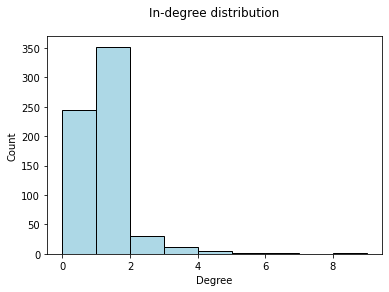

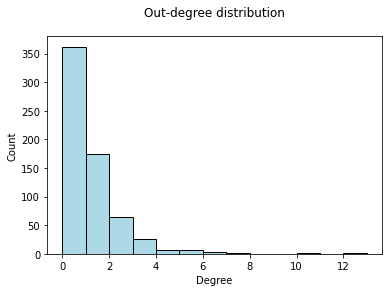

In [450]:
## Plot degree distributions
plt.title("In-degree distribution",pad = 20.0)
plt.hist(in_deg, bins = np.arange(np.min(in_deg), np.max(in_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

plt.title("Out-degree distribution",pad = 20.0)
plt.hist(out_deg, bins = np.arange(np.min(out_deg), np.max(out_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

**Figure C.2.1.1:** From the above degree distribution plots, we see that both the in-degree an out-degree distrbutions follow a pattern visibly similar to that of a power law. This would make since, since real social networks tend to be scale-free networks following with degree distribution following a power law. **SOURCE**

**C.2.2 Estimating the Degree Exponents**

In [451]:
in_degrees = [d for n,d in G.in_degree()]
out_degrees = [d for n,d in G.out_degree()]
all_degrees = [d for n,d in G.degree()]

in_alpha = powerlaw.Fit(in_degrees).alpha 
out_alpha = powerlaw.Fit(out_degrees).alpha 
all_alpha = powerlaw.Fit(all_degrees).alpha 

print('The degree exponent for in-, out- and total- degree distribution is {}, {} and {}.'.format(in_alpha, out_alpha, all_alpha))

Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 16%
xmin progress: 33%
xmin progress: 50%
xmin progress: 66%
xmin progress: 83%
Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 12%
xmin progress: 25%
xmin progress: 37%
xmin progress: 50%
xmin progress: 62%
xmin progress: 75%
xmin progress: 87%
Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 11%
xmin progress: 22%
xmin progress: 33%
xmin progress: 44%
xmin progress: 55%
xmin progress: 66%
xmin progress: 77%
xmin progress: 88%
The degree exponent for in-, out- and total- degree distribution is 9.5381097740159, 5.934757979067971 and 4.7074666203055155.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


The result shows that $\gamma_{in} = 9.54$, $\gamma_{out} = 5.93$, $\gamma_{all} = 4.71$. According to Chapter 4 of Network Science [9], $$p_{k_{in}} ∼ k^{−\gamma{in}}, p_{k_{out}} ∼ k^{−\gamma{out}}$$
We could draw the plot of $k^{−\gamma{in}}$, $k^{−\gamma{out}}$ and $k^{−\gamma{all}}$:

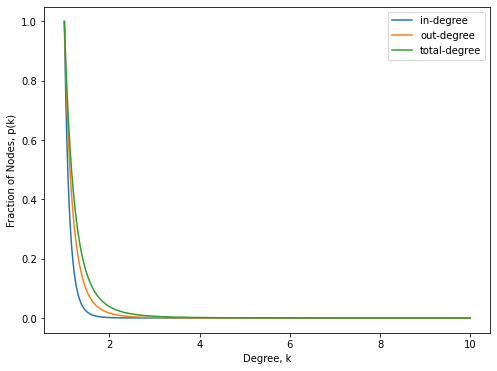

In [452]:
import matplotlib.pyplot as plt

# plot the there line in the same figure
plt.figure(figsize = (8,6))
x=np.linspace(1,10,1000) 
y_in=[np.power(k,-in_alpha) for k in x] 
y_out=[np.power(k,-out_alpha) for k in x] 
y_all=[np.power(k,-all_alpha) for k in x] 

plt.plot(x,y_in,label='in-degree') 
plt.plot(x,y_out,label='out-degree') 
plt.plot(x,y_all,label='total-degree') 
plt.ylabel("Fraction of Nodes, p(k)")
plt.xlabel('Degree, k')
plt.legend()
plt.show()

**Figure C.2.2.1:** From the plot above, we observe that the fraction of nodes with high in-degree decreases faster compared to out-degree. Consequently, there are more nodes with high out-degree than high in-degree, i.e., more users that mention/retweet other users' tweets a lot compared to being mentioned/retweeted themselves. This makes since, since the network includes nodes with no outdegree, i.e., users that do not mention others, but are only mentioned and retweeted by others. These users are, typically, political organizations, NGOs and accounts of political parties. 

In [453]:
## Most connected users
in_deg_dict = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(in_deg_dict, key=in_deg_dict.get, reverse=True)[:10])
print(" ")
out_deg_dict = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(out_deg_dict, key=out_deg_dict.get, reverse=True)[:10])

Top most in-degree connected users: , ['alternativet_', 'KonservativeDK', 'venstredk', 'berlingske', 'metteabildgaard', 'SorenPape', 'Spolitik', 'radikale', 'MagnusBarsoe', 'RosaLundEl']
 
Top most out-degree connected users: , ['MarleneAmbo', 'Scheelsbeck', 'AneHalsboe', 'hannebjornk', 'PLindhoutTravel', 'martinlidegaard', 'ThDanielsen', 'SamiraNawa', 'jobywatermusic', 'LarsPrahm']


It is seen that the top 4 users with highest in-degree are ones that will have an out-degree of 0, since these the first three are political party accounts and the fourth one, news media. So far, it seems to be a pretty mixed bag in terms of top users and their party/political affiliation.

**C.2.3 In-/out-degree Across Party Affiliation**

In [454]:
## Create dict containing party affiliation as node attributes

# Initialize empty dict
empty_dict = dict.fromkeys(range(0, len(tweets_w_mentions)))

# Loop through all nodes and add its corresponding party as node attribute
for i in tqdm(range(len(G.nodes))):
    try:
        j = np.where(tweets_w_mentions["user_handle"] == list(G.nodes)[i])[0][0]
        empty_dict[i] = {'party':list(tweets_w_mentions['party'])[j], 'pol_spectrum':list(tweets_w_mentions['pol_spectrum'])[j]}
    
    # For the users not included in the dataset, but only mentioned by other users, set party affiliation as "unk"    
    except IndexError: 
        empty_dict[i] = {'party':"unk", 'pol_spectrum': "unk"}

  0%|          | 0/646 [00:00<?, ?it/s]

In [455]:
# Change the key values to the user handles
empty_dict = dict(zip(list(G.nodes),list(empty_dict.values()))) 

In [456]:
# Set node attributes from the party affiliation dict we just defined
nx.set_node_attributes(G, empty_dict)

In [457]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

out_deg_A = []
out_deg_B = []
out_deg_C = []
out_deg_D = []
out_deg_F = []
out_deg_I = []
out_deg_K = []
out_deg_M = []
out_deg_O = []
out_deg_Q = []
out_deg_V = []
out_deg_Æ = []
out_deg_Ø = []
out_deg_Å = []
out_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):

    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(G.in_degree(node))
        out_deg_A.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(G.in_degree(node))
        out_deg_B.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(G.in_degree(node))
        out_deg_C.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(G.in_degree(node))
        out_deg_D.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(G.in_degree(node))
        out_deg_F.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(G.in_degree(node))
        out_deg_I.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(G.in_degree(node))
        out_deg_K.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(G.in_degree(node))
        out_deg_M.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(G.in_degree(node))
        out_deg_O.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(G.in_degree(node))
        out_deg_Q.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(G.in_degree(node))
        out_deg_V.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(G.in_degree(node))
        out_deg_Æ.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(G.in_degree(node))
        out_deg_Ø.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(G.in_degree(node))
        out_deg_Å.append(G.out_degree(node))

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(G.in_degree(node))
        out_deg_UDEN.append(G.out_degree(node))

  0%|          | 0/646 [00:00<?, ?it/s]

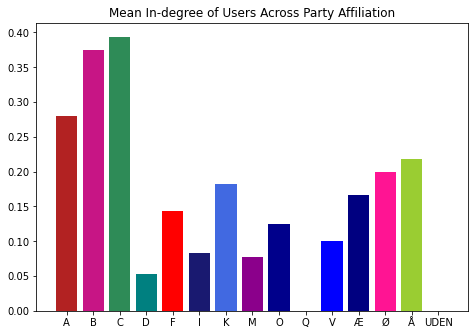

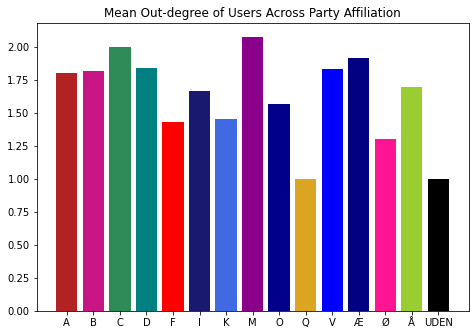

In [458]:
unique_parties_lst = ['A', 'B', 'C', 'D', 'F', 'I', 'K', 'M', 'O', 'Q', 'V', 'Æ', 'Ø', 'Å', 'UDEN']


color_dict_ = {"firebrick": "A", "mediumvioletred": "B", "seagreen": "C", "teal": "D", "red": "F", "midnightblue": "I", 
              "royalblue": "K", "darkmagenta": "M", "darkblue": "O", "goldenrod": "Q", "blue": "V", "navy": "Æ",
              "deeppink": "Ø", "yellowgreen": "Å", "black": 'UDEN'}

def party_aff_plot(unique_list, count_list, title, color_dict):
    """Make barplot of party affiliation in community.

        Args:
            unique_list (list): Output from unique_and_count(), list of unique parties present in community.
            count_list (list): Output from unique_and_count(), count of party occurence.
            title (str): Plot title.
            color_dict (dict): Dictionary of parties and their respective colors.

    """
    rev_subs = {v:k for k, v in color_dict.items()}

    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    parties = unique_list
    counts = count_list
    
    ax.bar(parties,counts, color = [rev_subs.get(item,item)  for item in unique_list])
    plt.title(title)
    plt.show()



party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean In-degree of Users Across Party Affiliation",color_dict_)
party_aff_plot(unique_parties_lst, [np.mean(out_deg_A), np.mean(out_deg_B), np.mean(out_deg_C), np.mean(out_deg_D), np.mean(out_deg_F), np.mean(out_deg_I), np.mean(out_deg_K), np.mean(out_deg_M), np.mean(out_deg_O), np.mean(out_deg_Q), np.mean(out_deg_V), np.mean(out_deg_Æ), np.mean(out_deg_Ø), np.mean(out_deg_Å), np.mean(out_deg_UDEN)], "Mean Out-degree of Users Across Party Affiliation",color_dict_)

**Figure C.2.3.1:** The plots above show the mean in/out-degree of users from different parties. The parties A, B and C have both high mean out and in-degree. These are traditioally recognized Danish political parties that have been both in parliament and in government. Meanwhile, it can be seen how newer parties such as Q, Å, D and M have comparatively low in-degrees while having higher out-degrees. They tend to mention others more than being mentioned themselves. This would also make since, since they are relative newcomers in Danish politics.

**C.2.4 Visualization of Network**

In [459]:
# Convert to undirected graph for visualization purposes (so we do not end up with a lot of arrows)
G_visualize = G.to_undirected()

In [460]:
def color_maps(G_visualize, pol_spec):
    """Create color maps for nodes and edges.

        Args:
            G_visualize (NetworkX Graph object): Social network graph to create color maps for.
            pol_spec (bool): Whether not to use color maps for political affiliation.

        Returns:
            list: Color map for nodes.
            list: Color map for edges.
    """
    # Get in-degrees in dict
    degree_dict = dict(G_visualize.degree)
    if not pol_spec:
        
        ## Node color map ##
        color_map_nodes = []

        # Define colors for all parties
        for node in tqdm(list(G_visualize.nodes())):

            if nx.get_node_attributes(G_visualize,'party')[node] == 'A': # Soc. Dem.
                color_map_nodes.append("firebrick")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'B': # Radikale venstre
                color_map_nodes.append("mediumvioletred")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'C': # Konservative
                color_map_nodes.append("seagreen")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'D': # Nye Borgerlige
                color_map_nodes.append("teal")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'F': # SF
                color_map_nodes.append("red")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'I': # LA
                color_map_nodes.append("midnightblue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'K': # KD
                color_map_nodes.append("royalblue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'M': # Moderaterne
                color_map_nodes.append("darkmagenta")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'O': # DF
                color_map_nodes.append("darkblue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Q': # Frie grønne
                color_map_nodes.append("goldenrod")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'V': # Venstre
                color_map_nodes.append("blue")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Æ': # DK demokraterne
                color_map_nodes.append("navy")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Ø': # Enhedslisten
                color_map_nodes.append("deeppink")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'Å': # Alternativet
                color_map_nodes.append("yellowgreen")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'UDEN':
                color_map_nodes.append("black")

            elif nx.get_node_attributes(G_visualize,'party')[node] == 'unk':
                color_map_nodes.append("dimgray")

            else:
                color_map_nodes.append("lightslategray")

        ## Edge color map ##
        color_map_edge = []

        # Define colors for all parties
        for i in tqdm(list(G_visualize.edges())):

            if nx.get_node_attributes(G_visualize, 'party')[i[0]] != nx.get_node_attributes(G_visualize, 'party')[i[1]]:
                color_map_edge.append("slategray") # Links across party affiliation

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'A': # A-A
                color_map_edge.append("tomato")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'B': # B-B
                color_map_edge.append("hotpink")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'C': # C-C
                color_map_edge.append("darkseagreen")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'D': # D-D
                color_map_edge.append("cadetblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'F': # F-F
                color_map_edge.append("orangered")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'I': # I-I
                color_map_edge.append("lightskyblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'K': # K-K
                color_map_edge.append("cornflowerblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'M': # M-M
                color_map_edge.append("darkviolet")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'O': # O-O
                color_map_edge.append("dodgerblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Q': # Q-Q
                color_map_edge.append("yellow")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'V': # V-V
                color_map_edge.append("steelblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Æ': # Æ-Æ
                color_map_edge.append("skyblue")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Ø': # Ø-Ø
                color_map_edge.append("lightpink")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'Å': # Å-Å
                color_map_edge.append("lime")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'UDEN': # UDEN-UDEN
                color_map_edge.append("darkslategray")

            elif nx.get_node_attributes(G_visualize, 'party')[i[0]] == 'unk': # unk-unk
                color_map_edge.append("dimgrey")

            else:
                color_map_edge.append("slategrey")
    else:
        ## Node color map ##
        color_map_nodes = []

        # Define colors for all parties
        for node in tqdm(list(G_visualize.nodes())):

            if nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'left wing': 
                color_map_nodes.append("firebrick")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'right wing': 
                color_map_nodes.append("blue")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'center': 
                color_map_nodes.append("darkmagenta")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'none': 
                color_map_nodes.append("darkslategray")

            elif nx.get_node_attributes(G_visualize,'pol_spectrum')[node] == 'unk': 
                color_map_nodes.append("dimgrey")


        ## Edge color map ##
        color_map_edge = []

        # Define colors for all parties
        for i in tqdm(list(G_visualize.edges())):

            if nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] != nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[1]]:
                color_map_edge.append("slategray") # Links across party affiliation

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'left wing': # left wing-left wing
                color_map_edge.append("tomato")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'right wing': # right wing-right wing
                color_map_edge.append("steelblue")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'center': # center-center
                color_map_edge.append("darkviolet")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'none': # center-center
                color_map_edge.append("slategray")

            elif nx.get_node_attributes(G_visualize, 'pol_spectrum')[i[0]] == 'unk': # center-center
                color_map_edge.append("grey")
                
    return color_map_nodes, color_map_edge, degree_dict

# Create a color map for the parties
color_map_legend = {}
color_map_legend['Frie Grønne'] = 'goldenrod'
color_map_legend['Enhedslisten'] = 'deeppink'
color_map_legend['SF'] = 'red'
color_map_legend['Alternativet'] = 'yellowgreen'
color_map_legend['Soc. Dem.'] = 'firebrick'
color_map_legend['Radikale Venstre'] = 'mediumvioletred'
color_map_legend['Moderaterne'] = 'darkmagenta'
color_map_legend['KD'] = 'royalblue'
color_map_legend['V'] = 'blue'
color_map_legend['DF'] = 'darkblue'
color_map_legend['LA'] = 'midnightblue'
color_map_legend['De Konservative'] = 'seagreen'
color_map_legend['DKdemokraterne'] = 'navy'
color_map_legend['Nye Borgerlige'] = 'teal'
color_map_legend['unk'] = 'dimgrey'
color_map_legend['Non-affiliated'] = 'black'

# Create a color map for idiological affiliation
color_map_legend_pol_spectrum = {}
color_map_legend_pol_spectrum['Left Wing'] = 'firebrick'
color_map_legend_pol_spectrum['Right Wing'] = 'blue'
color_map_legend_pol_spectrum['Center'] = 'darkmagenta'
color_map_legend_pol_spectrum['Non-affiliated'] = 'darkslategray'
color_map_legend_pol_spectrum['unk'] = 'dimgrey'

unique_parties = ['Frie Grønne', 'Enhedslisten', 'SF', 'Alternativet', 'Soc. Dem.', 'Radikale Venstre', 'Moderaterne', 'KD', 'V', 'DF', 'LA', 'De Konservative', 'DKdemokraterne', 'Nye Borgerlige', 'unk', 'Non-affiliated']
unique_pol_spec = ['Left Wing', 'Right Wing', 'Center', 'Non-affiliated', 'unk']

## Create legend for plot ##
rgb = colors.to_rgba_array([color_map_legend[party] for party in unique_parties])
handles_dict = {patches.Patch(color = rgb, label = party) for party, rgb in color_map_legend.items()}

rgb_pol_spec = colors.to_rgba_array([color_map_legend_pol_spectrum[party] for party in unique_pol_spec])
handles_dict_pol_spec = {patches.Patch(color = rgb, label = party) for party, rgb in color_map_legend_pol_spectrum.items()}

In [461]:
# Get color maps for nodes and edges for visualizing network
color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = False)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:16<00:00, 121.59it/s]


BarnesHut Approximation  took  2.86  seconds
Repulsion forces  took  12.93  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds


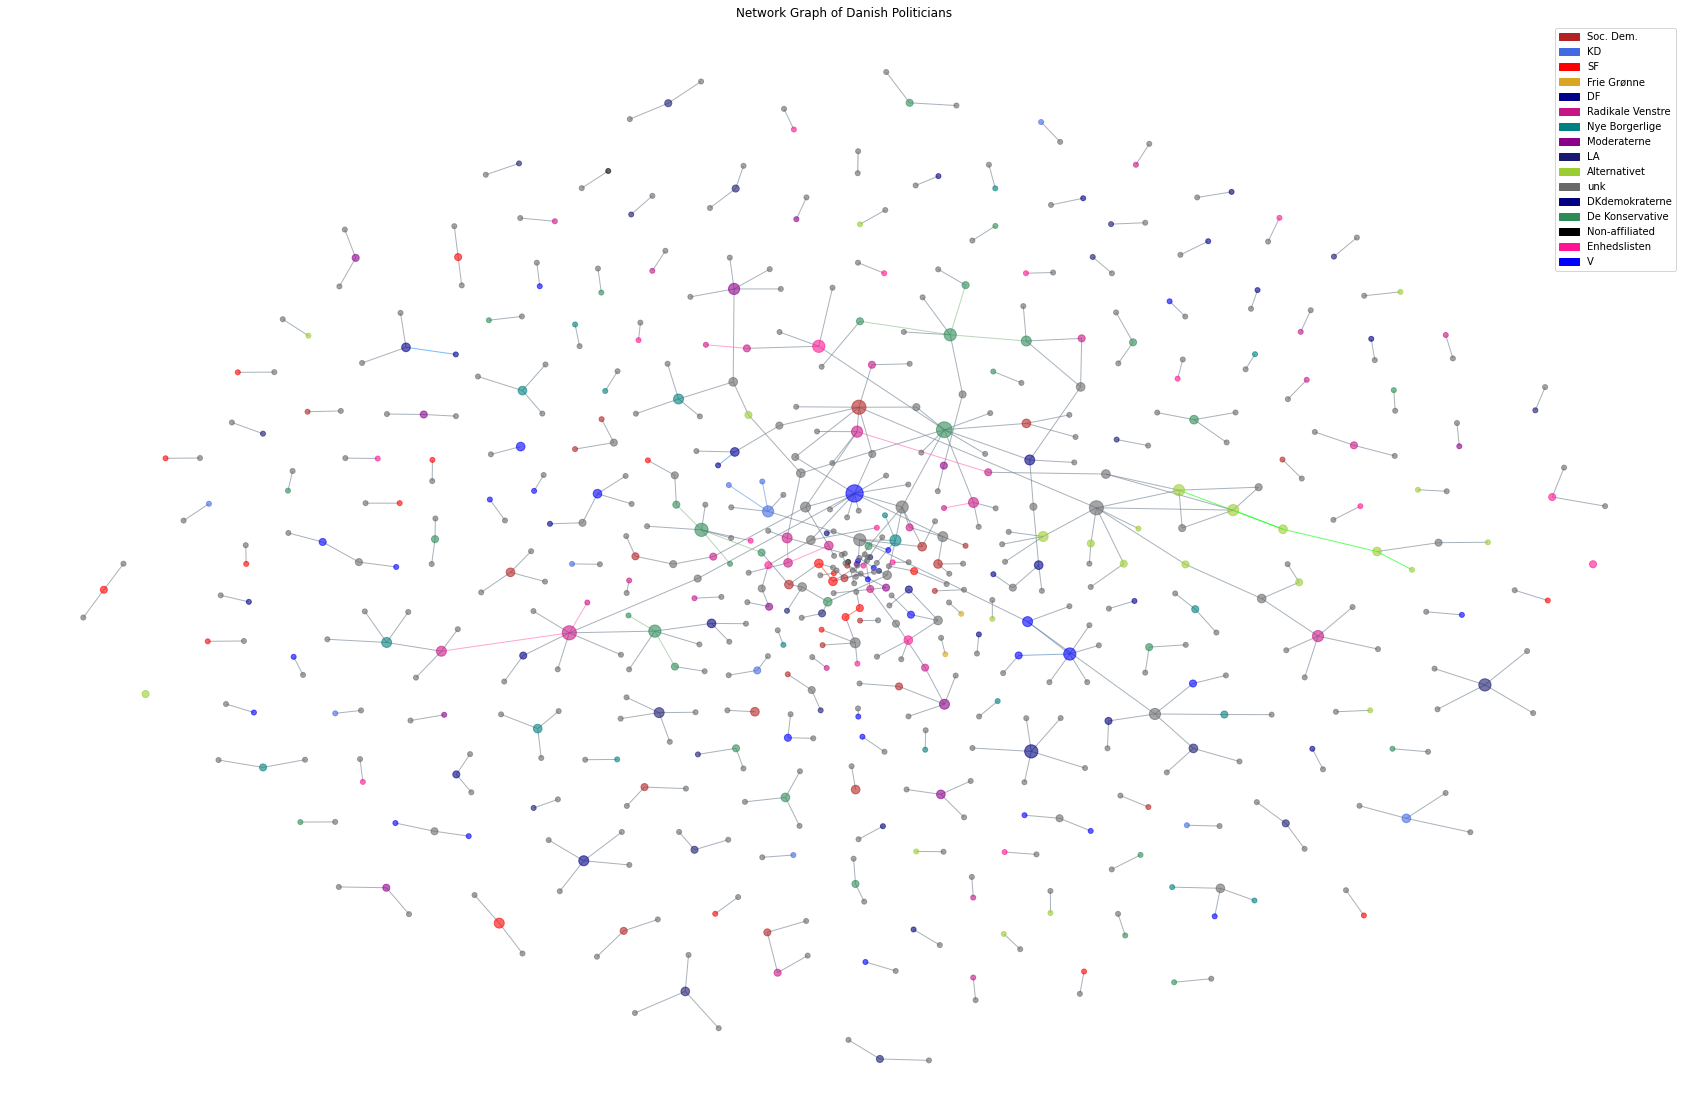

In [462]:
## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions_full = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions_full,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict)
plt.show()

**Figure C.2.4.1:** The network of Danish parliamentary candidates and their mentioned/retweeted users on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to party affiliation. We can see how there is one large connected component with several smaller components spread around.

In [463]:
# Extract largest component
gcc = max(nx.weakly_connected_components(G), key=len)
gcc_subgraph = G.subgraph(gcc)
gcc_visualize = gcc_subgraph.to_undirected()

color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = False)

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:04<00:00, 498.28it/s]


BarnesHut Approximation  took  0.72  seconds
Repulsion forces  took  2.93  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


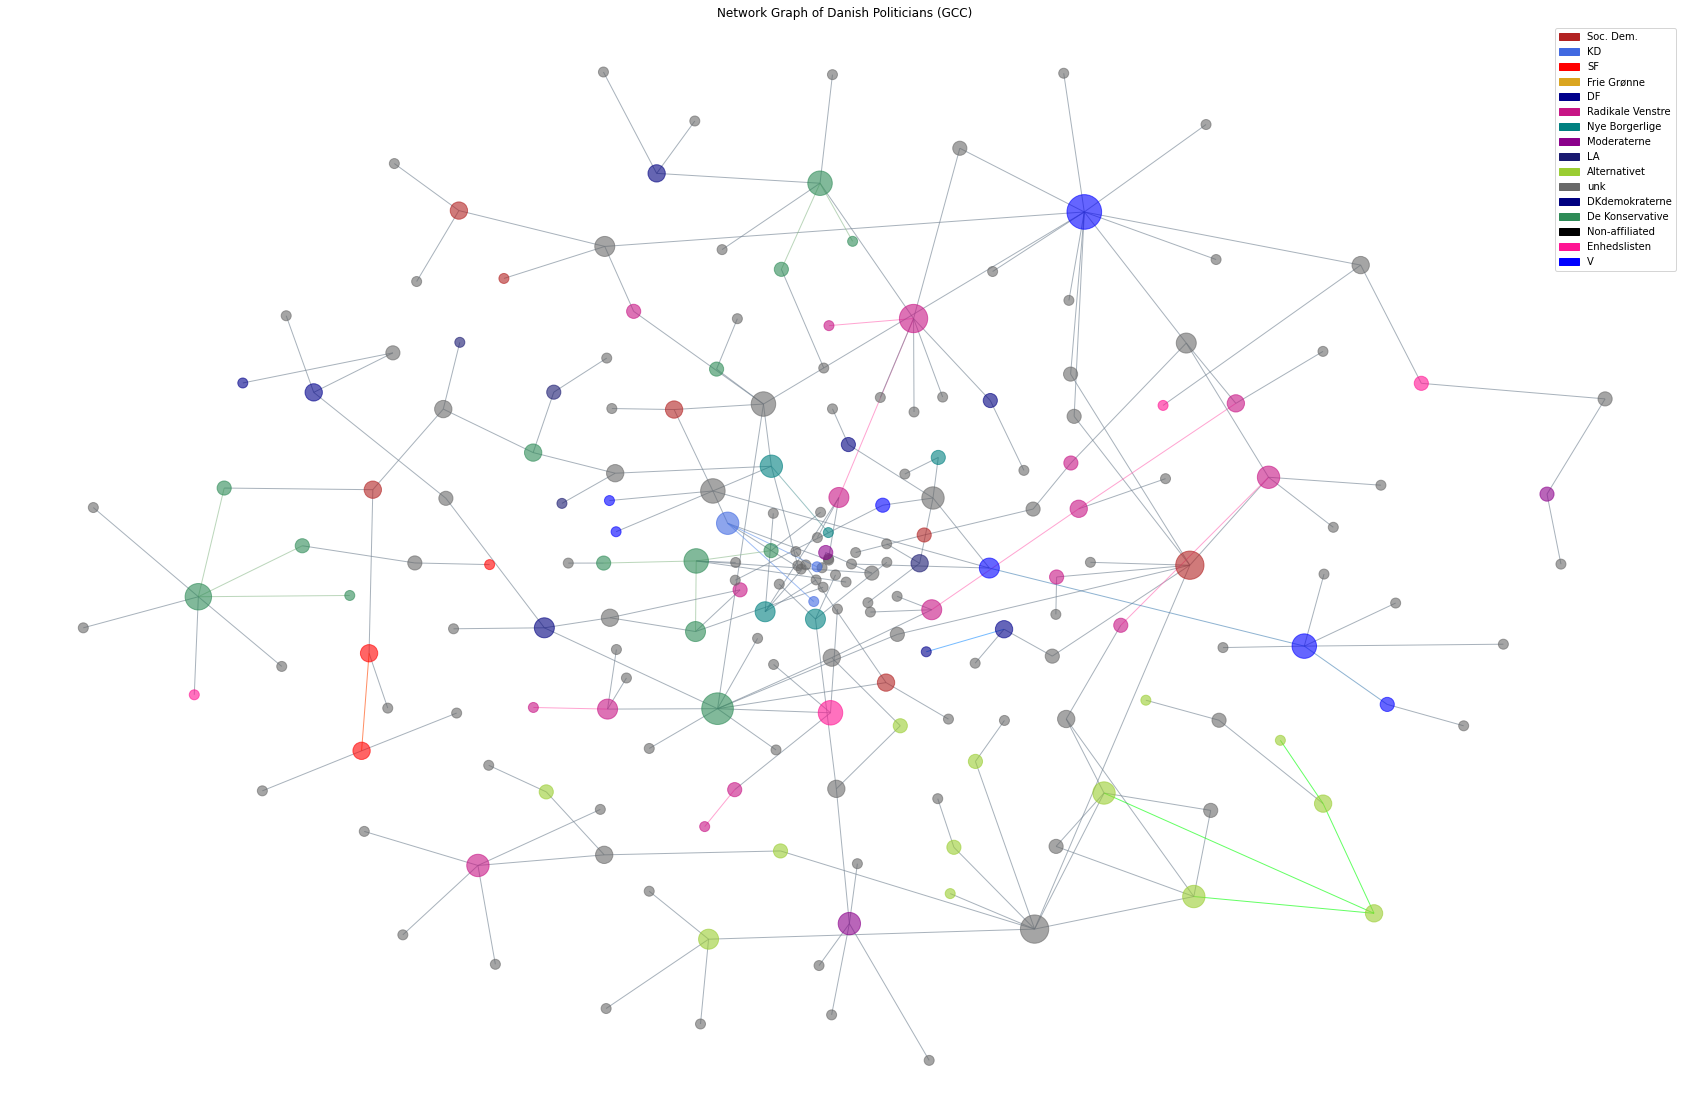

In [464]:
## Plotting network (GCC) ##
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions_gcc = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions_gcc,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict)
plt.show()

**Figure C.2.4.2:** The greatest connected component (GCC) in the network of Danish parliamentary candidates and their mentioned/retweeted users on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to party affiliation.

In [465]:
print("Number of nodes in GCC:")
print(len(gcc_visualize.nodes))

Number of nodes in GCC:
205


In [466]:
print("Number of edges in GCC:")
print(len(gcc_visualize.edges))

Number of edges in GCC:
217


In [467]:
# Get color maps for nodes and edges for visualization
color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = True)

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

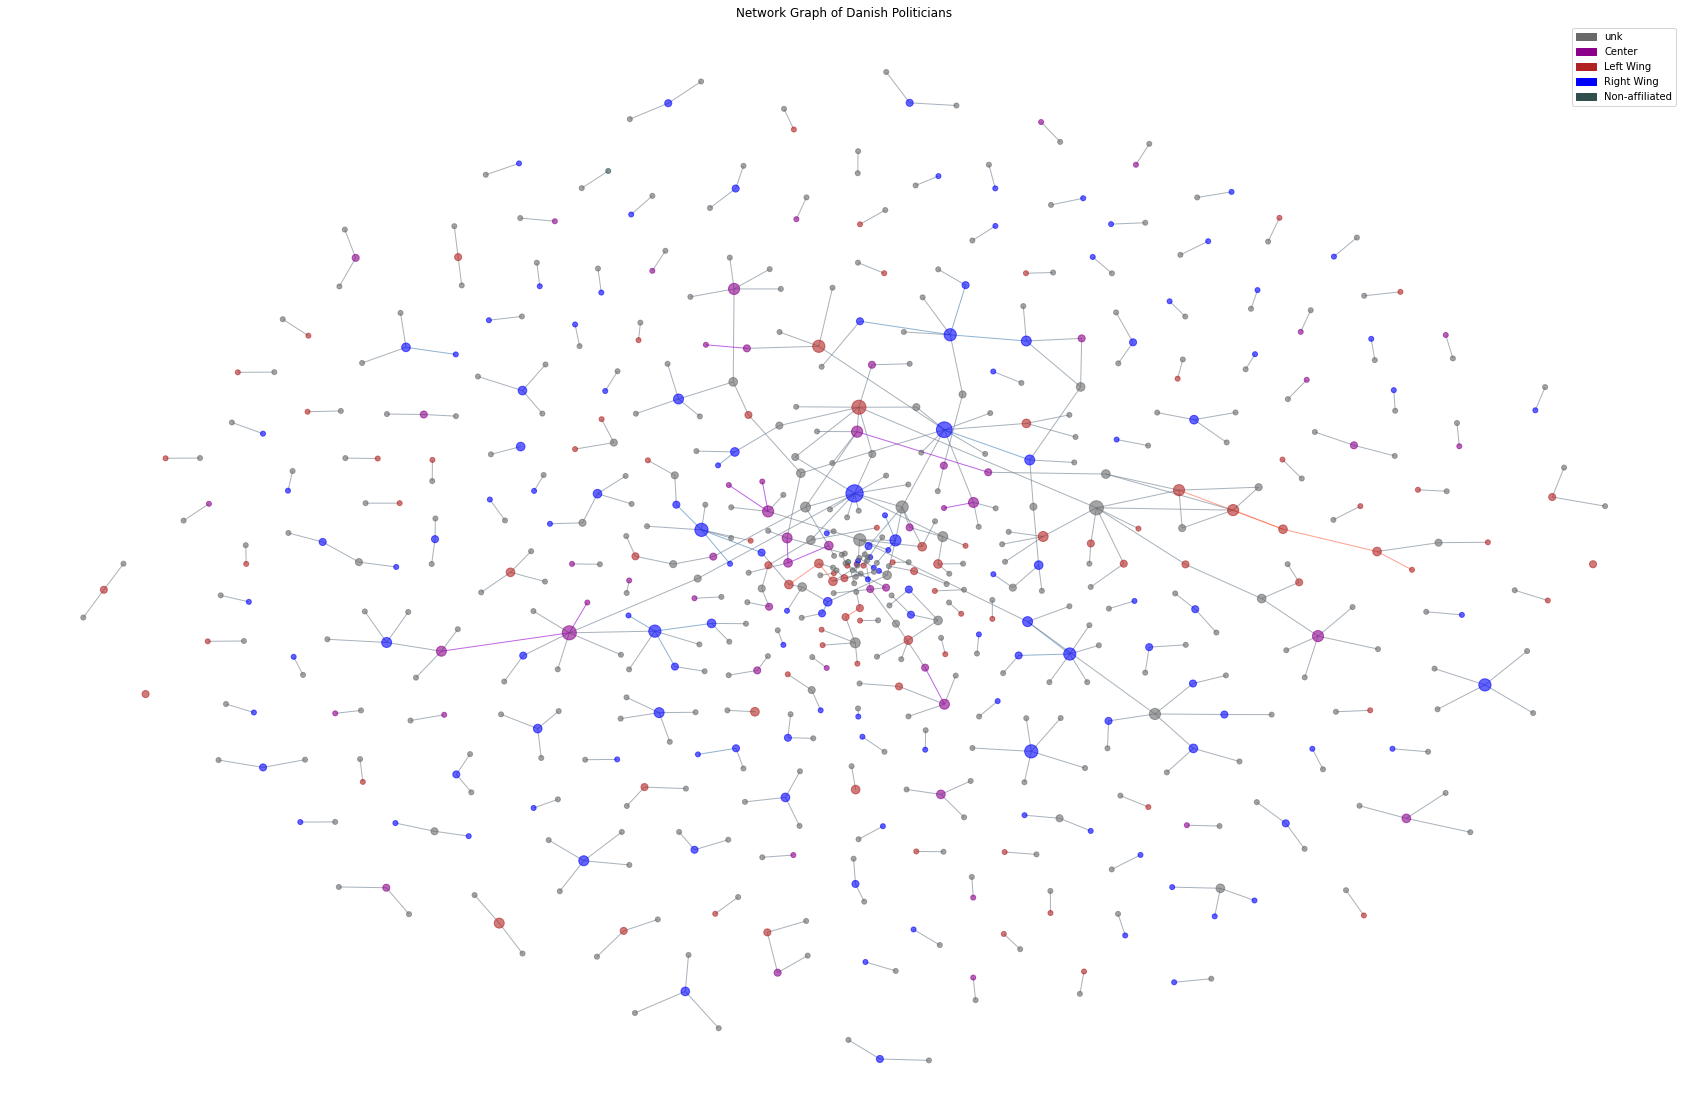

In [468]:
## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

nx.draw_networkx(G_visualize, positions_full,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend_pol_spectrum.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

**Figure C.2.4.3:** The network of Danish parliamentary candidates and their mentioned/retweeted users on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to idiological affiliation.

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

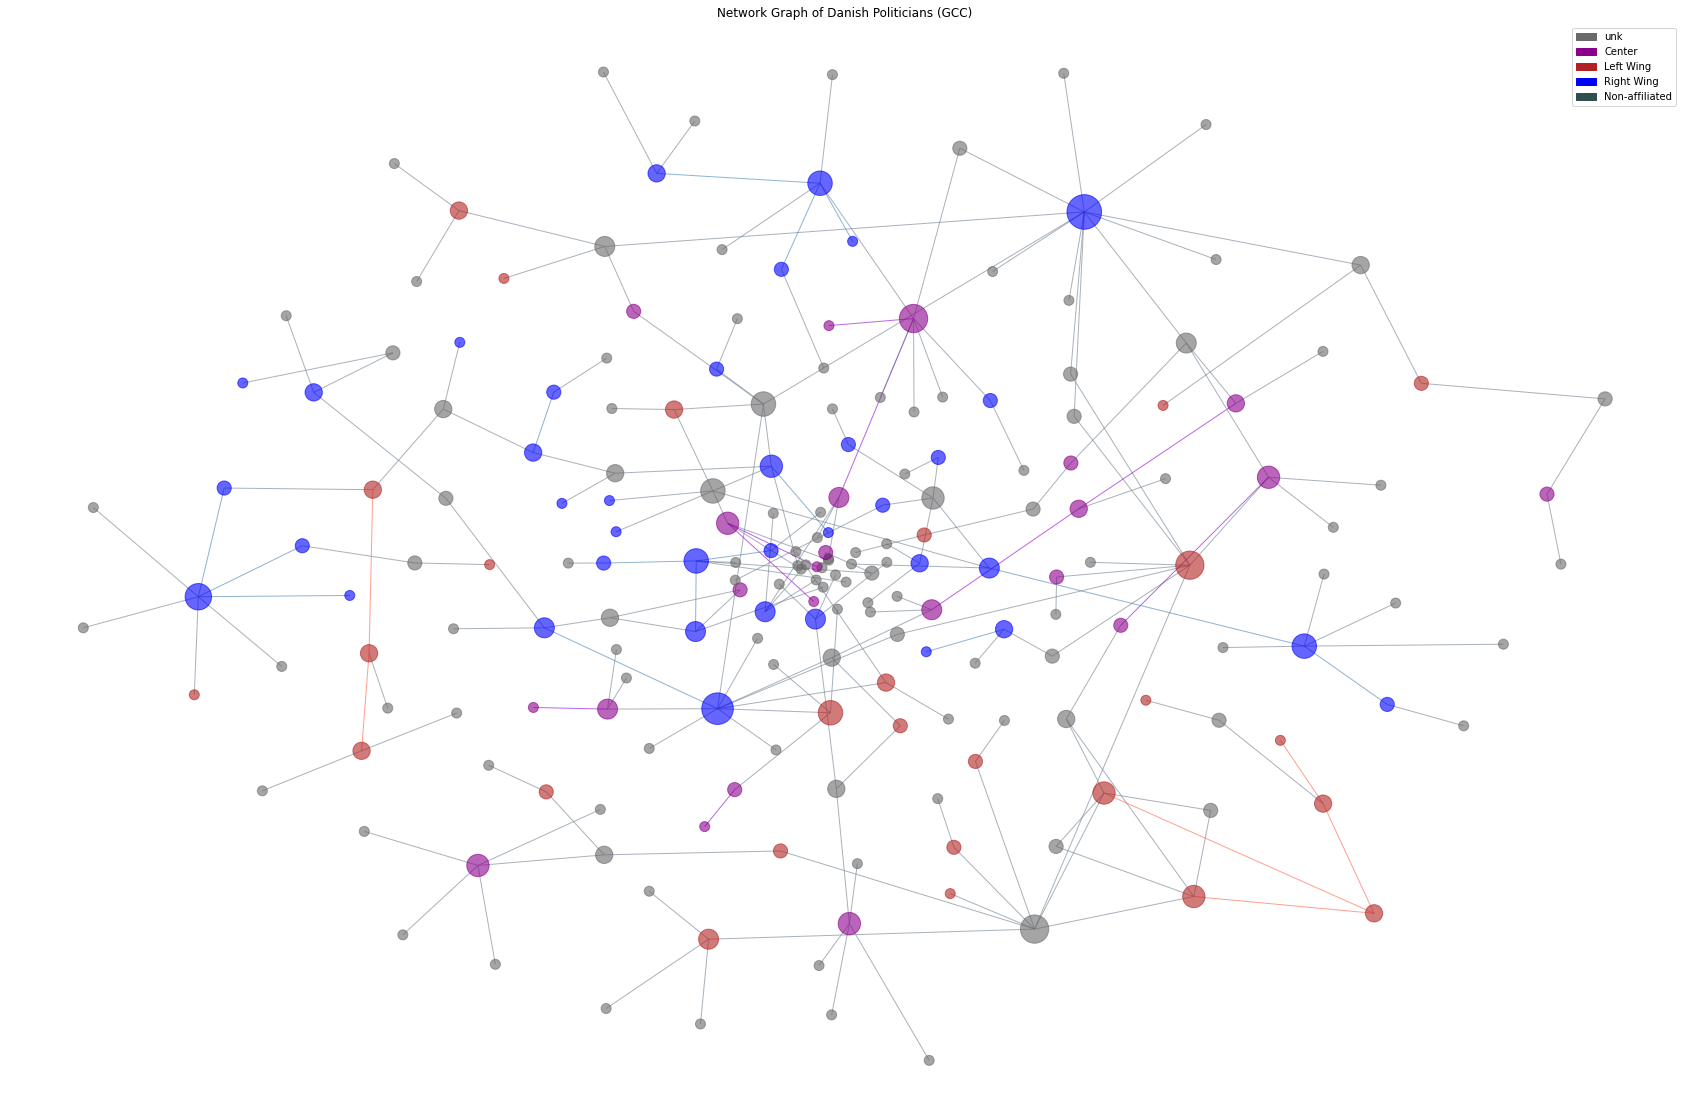

In [469]:
# Get color maps for nodes and edges
color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = True)

## Plotting network (GCC) ##
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

nx.draw_networkx(gcc_visualize, positions_gcc,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend_pol_spectrum.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

**Figure C.2.4.4:** The greatest connected component (GCC) in the network of Danish parliamentary candidates and their mentioned/retweeted users on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to idiological affiliation.

From the visualizations of both the whole network and its GCC its hard to visually identify communities of users. Consequently, we apply an algorithm for this purpose in the next section.

## C.3 Finding Communities

We start by cleaning the tweets of hyperlinks and HTML code, so that we can use it for visualizing wordclouds later

In [470]:
def get_links(tweet):
    """Find links in tweets and remove them.

        Args:
            tweet (str): The tweet to find links in.

        Returns:
            str: The cleaned tweet.
    """
    tweet = re.sub('\.*amp\.*', '', tweet.lower())
    
    return re.sub("(http|https)://[\w\-]+(\.[\w\-]+)+\S*",'', tweet)

In [471]:
# Apply function on all rows so that tweets are clean of any hyperlinks
tweets_w_mentions['tweet'] = tweets_w_mentions['tweet'].apply(get_links)

<ipython-input-471-b94dca208fc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_w_mentions['tweet'] = tweets_w_mentions['tweet'].apply(get_links)


Tokenize tweets:

In [472]:
# Define stopwords
stop_words = set(stopwords.words('danish'))
tokenizer = RegexpTokenizer(r'\w+') 

def tweet_tokenizer(tweet):
    """Clean and tokenize tweet.

        Args:
            tweet (str): The tweet to clean and tokenize.

        Returns:
            str: The cleaned tweet.
    """
    wrd_tok = tokenizer.tokenize(tweet)
    
    # Set to lowercase and remove "RT" and "@" from tweets
    clean_tweet = [w.lower() for w in wrd_tok if not w.lower() in stop_words and not w.lower() in ['rt', '@', 'så', 'al','dkpol']]
    
    return clean_tweet

In [473]:
tweets_w_mentions['tokenized'] = tweets_w_mentions['tweet'].apply(tweet_tokenizer)

<ipython-input-473-dc711bb53213>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_w_mentions['tokenized'] = tweets_w_mentions['tweet'].apply(tweet_tokenizer)


In [474]:
def mention_remover(tweet, mentions):
    """Remove mentions from tweet.

        Args:
            tweet (str): The tweet to clean and tokenize.
            mentions (list): List of mentions to remove from tweet.

        Returns:
            str: The cleaned tweet.
    """
    for i in mentions:
        try:
            tweet.remove(i.lower())
        except:
            pass

In [475]:
tweets_w_mentions.apply(lambda x: mention_remover(x['tokenized'], x['mention']), axis=1)

0        None
1        None
3        None
4        None
5        None
         ... 
53335    None
53336    None
53337    None
53338    None
53340    None
Length: 40780, dtype: object

In [476]:
tweets_w_mentions.head(5)

tweetID     userID  \
0  1587190794502422528  606561223   
1  1587154827485782016  606561223   
3  1586771334872408064  606561223   
4  1586349096910061568  606561223   
5  1586262864192737280  606561223   

                                               tweet  user_handle party  \
0  rt @mettegjerskov: så er der klar tale fra de ...  LeaWermelin     A   
1  rt @verdensskove: sådan så det ud da @maivilla...  LeaWermelin     A   
3  rt @danmarksnatur: 85 procent af vælgerne støt...  LeaWermelin     A   
4  rt @idaauken: regeringen har været den mest mi...  LeaWermelin     A   
5  rt @danva1926: sikring af det rene drikkevand ...  LeaWermelin     A   

  pol_spectrum                                            mention  \
0    left wing                                    [MetteGjerskov]   
1    left wing  [verdensskove, MaiVilladsen, sofiecn, PiaOlsen...   
3    left wing                                    [DanmarksNatur]   
4    left wing           [IdaAuken, BirdLifeDanmark, LeaWermelin]   
5    left wing                                        [DANVA1926]   

                                           tokenized  
0  [klar, tale, blå, naturen, vigtigt, alligevel,...  
1                                    [modtog, lille]  
3  [85, procent, vælgerne, støtter, forbud, brug,...  
4       [regeringen, mest, miljøvenlige, tak, bravo]  
5  [sikring, rene, drikkevand, danskerne, fremtid...

In [477]:
tweets_w_mentions.tail(5)

tweetID      userID  \
53335  1401391375439044608  3300730179   
53336  1401386037860052992  3300730179   
53337  1401383460032352512  3300730179   
53338  1397834987446079488  3300730179   
53340   558551516962107392   479025309   

                                                   tweet user_handle party  \
53335  rt @hagbard_dane: jeg er færdig af grin. alvor...   line_aaen     Å   
53336  rt @alternativet_: “før jeg vil snakke om demo...   line_aaen     Å   
53337  rt @nhoerup: vi skal give familierne omsorg, s...   line_aaen     Å   
53338  @thedorteolsen enig! det er et problem at man ...   line_aaen     Å   
53340                                   @aboveandbeyond          one  UDEN   

      pol_spectrum                        mention  \
53335    left wing  [Hagbard_Dane, alternativet_]   
53336    left wing                [alternativet_]   
53337    left wing                [NHOERUP, Mira]   
53338    left wing                [TheDorteOlsen]   
53340         none               [aboveandbeyond]   

                                               tokenized  
53335  [færdig, grin, alvor, blandet, humor, måde, fo...  
53336  [før, snakke, demokrati, én, ting, bør, starte...  
53337  [give, familierne, omsorg, får, overskud, give...  
53338  [enig, problem, omtaler, personer, udstået, st...  
53340                                                 []

**C.3.1 Identifying Communities**

To identify communities within the network we grab the undirected version of the graph. The unsupervised Louvain algorithm is used for detecting the communities. It is a greedy algorithm for extracting communities from large networks by Blondel et. al. [1]. The algorithm seeks to obtain the maximum modularity for each iteration. We selected the Louvain algorithm to partition the network into communities instead of using the Girvan-Newman algorithm due to Louvain having faster runtime of $O(n · log n)$ compared to a runtime between $O(m^2n)$ to $O(n^5)$ for Girvan-Newman [8].

In [478]:
part = community_louvain.best_partition(G_visualize)

In [479]:
comms = np.unique(list(part.values()))

Given a graph $G$ with $|E(G)|=m$ and clustering of communities $\mathcal{C}=\left(C_1, \ldots, C_k\right)$ of $V(G)$ into communities $C_i$.
Modularity $Q(G, C)$ can be defined as:
$$
Q(G, \mathcal{C})=\frac{1}{2 m} \cdot \sum_{\substack{C_i \in \mathcal{C}}} \sum_{\substack{v, w \in V\left(C_i\right) \\ v \neq w}}\left[A_{v w}-\frac{d_G(v) \cdot d_G(w)}{2 m}\right]
$$
$A_{v w}$ is the indicator function: $A_{v w}= \begin{cases}1, & \text { if } v w \in E\left(C_i\right) \\ 0, & \text { if } v w \notin E\left(C_i\right)\end{cases}$
The sum is scaled by $\frac{1}{2 m}$ to obtain range for $Q(G, \mathcal{C})$ within $[-1,1]$ [7].

In [480]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in part.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(G_visualize, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9493148688046678


Since Q(G, C) > 0.3, the partition has resulted in a good community structure [2].

In [481]:
print("Number of found communities:")
print(max(comms))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
184
Number of communities with more than 3 nodes: 62


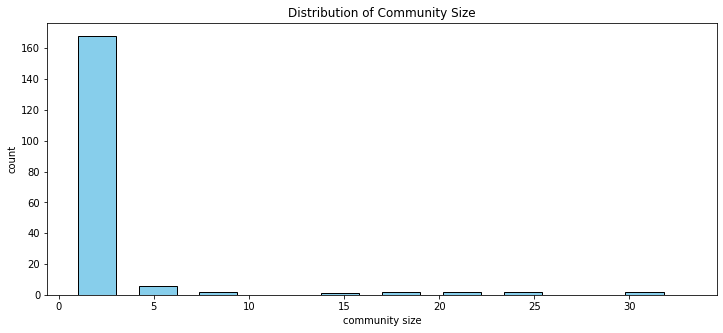

In [482]:
comms_sizes = [len(i) for i in comms_list]

plt.figure(figsize=(12,5))
plt.hist(comms_sizes,width=2,color='skyblue',edgecolor='k')
plt.xlabel('community size')
plt.ylabel('count')
plt.title('Distribution of Community Size')
plt.show()

**Figure C.3.1.1:** Histogram of community sizes.

In [483]:
# Reorganizing into dict
d_input = dict(part.items())
res = {}

for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

Extracting the 16 largest communities:

In [484]:
## Print top 16 communities and their sizes ##
c = 0
top_comms = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:16]
comm_tweets = []

for i,t in enumerate(top_comms):
    comm_tweets.append(np.concatenate(tweets_w_mentions.loc[tweets_w_mentions['user_handle'].isin(t[1])]['tokenized'].values))
    
    print(f"Community {i+1}. Size: {len(t[1])}")
    c += len(t[1])
    
print(f"\nCirca {int(np.round(c/len(G_visualize.nodes), 2)*100)}% of network nodes represented in these partitions.")

Community 1. Size: 33
Community 2. Size: 30
Community 3. Size: 24
Community 4. Size: 24
Community 5. Size: 21
Community 6. Size: 21
Community 7. Size: 19
Community 8. Size: 17
Community 9. Size: 16
Community 10. Size: 9
Community 11. Size: 8
Community 12. Size: 7
Community 13. Size: 6
Community 14. Size: 5
Community 15. Size: 5
Community 16. Size: 5

Circa 39% of network nodes represented in these partitions.


**C.3.2 Inspect Party Affiliation of Users in Top Nodes**

In [485]:
def get_parties(comm_users_list):
    """Get list of party affiliation for users in community.

        Args:
            comm_users_list (list): The list of users in a community.

        Returns:
            list: List of party affiliation of each user in community.
    """
    parties = []
    for i in comm_users_list:
        parties.append(nx.get_node_attributes(G_visualize, 'party')[i])
    
    return parties

In [486]:
def unique_and_count(parties_list):
    """Get list of unique parties in list of users in community and their respective counts in list also.

        Args:
            parties_list (list): Output from get_parties(), list of party affiliation of each user in community.

        Returns:
            list: List of unique parties present in community.
            list: Count of party occurence.
    """
    x = np.array(parties_list)
    unique_list = list(np.unique(x))
    
    count_list = []
    for i in unique_list:
        count = parties_list.count(i)
        count_list.append(count)
        
    return unique_list, count_list

color_dict = {"firebrick": "A", "mediumvioletred": "B", "seagreen": "C", "teal": "D", "red": "F", "midnightblue": "I", 
              "royalblue": "K", "darkmagenta": "M", "darkblue": "O", "goldenrod": "Q", "blue": "V", "navy": "Æ",
              "deeppink": "Ø", "yellowgreen": "Å", "black": 'UDEN', "dimgray": "unk"}

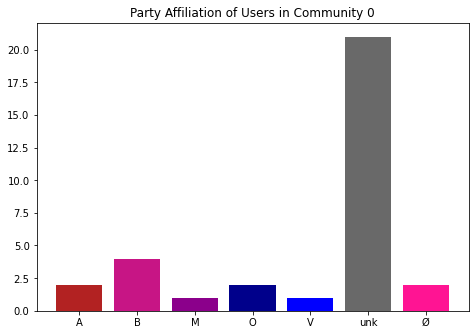

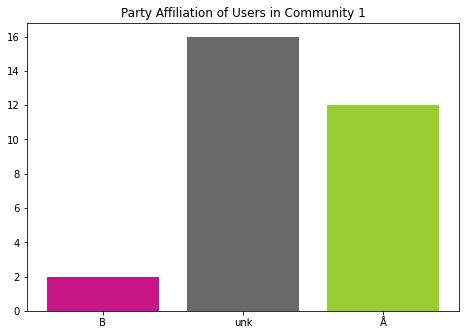

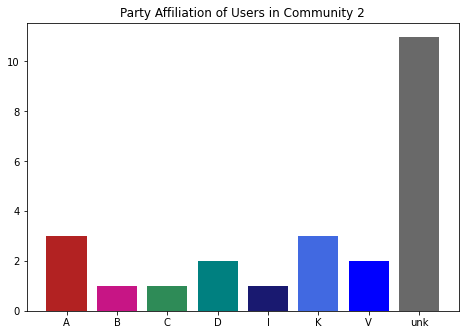

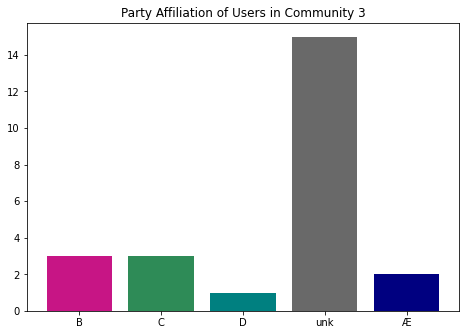

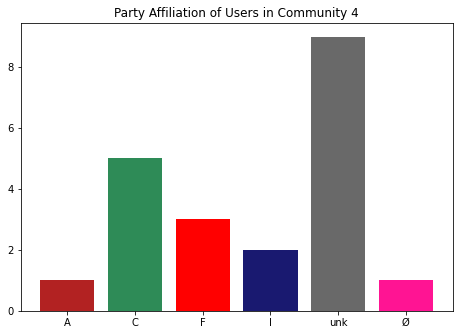

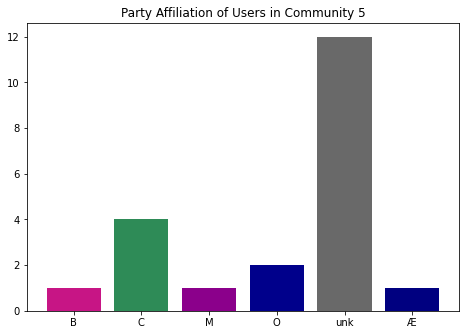

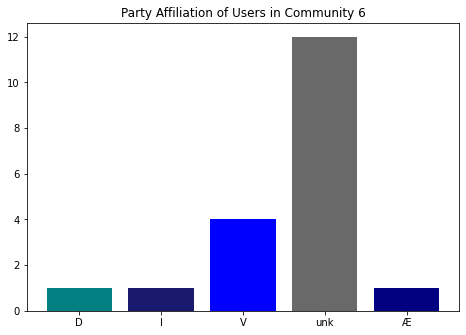

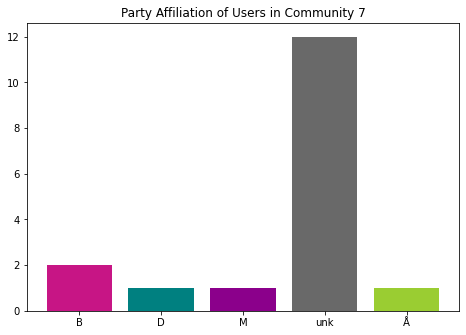

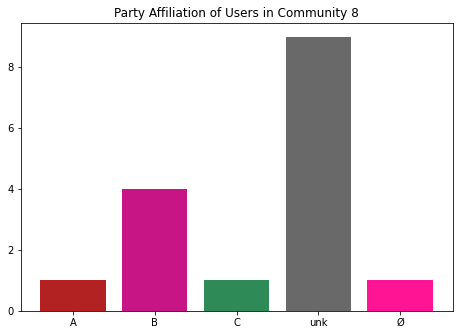

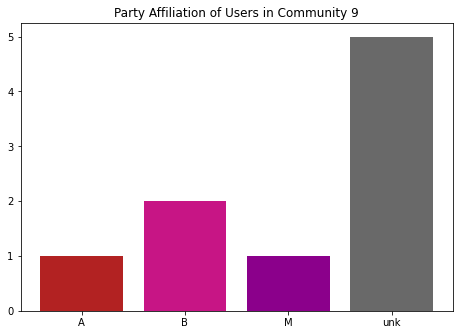

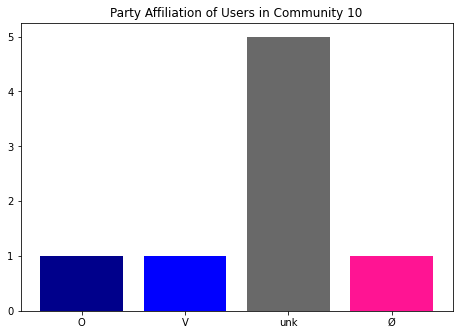

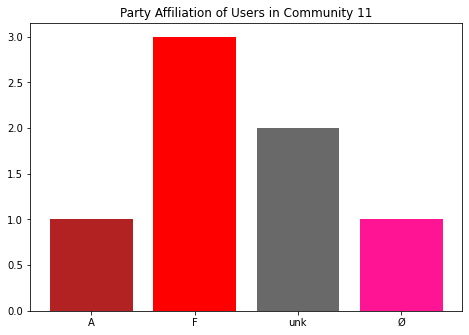

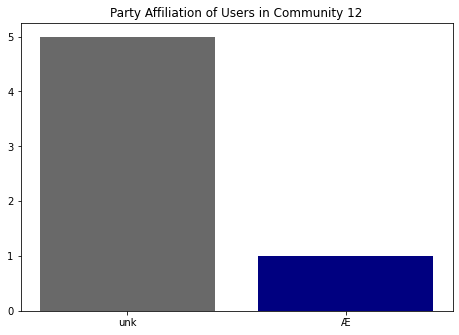

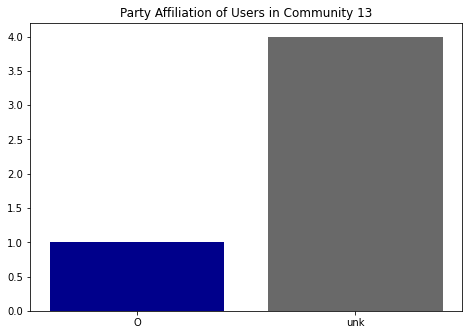

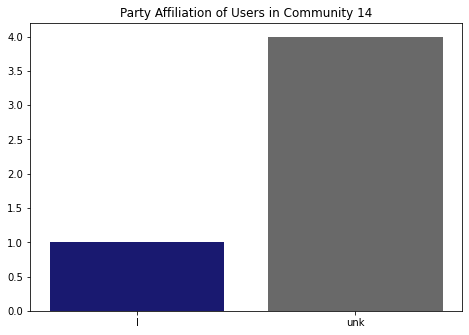

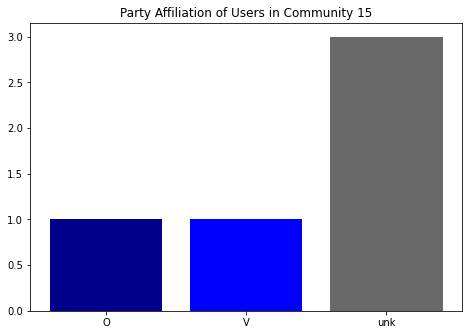

In [487]:
for i, _ in enumerate(top_comms):
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    party_aff_plot(unique_list, count_list, f"Party Affiliation of Users in Community {i}", color_dict)

**Figure C.3.2.1:** Among the found communities, community 0, 3, 4, 5, 6, 8 and 10 appear to have a mixture of parties from different idiological sides.

In [488]:
for i, _ in enumerate(top_comms):
    print(f"Parties in Community {i+1}:")
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    print(dict(zip(unique_list, count_list)))
    print(" ")

Parties in Community 1:
{'A': 2, 'B': 4, 'M': 1, 'O': 2, 'V': 1, 'unk': 21, 'Ø': 2}
 
Parties in Community 2:
{'B': 2, 'unk': 16, 'Å': 12}
 
Parties in Community 3:
{'A': 3, 'B': 1, 'C': 1, 'D': 2, 'I': 1, 'K': 3, 'V': 2, 'unk': 11}
 
Parties in Community 4:
{'B': 3, 'C': 3, 'D': 1, 'unk': 15, 'Æ': 2}
 
Parties in Community 5:
{'A': 1, 'C': 5, 'F': 3, 'I': 2, 'unk': 9, 'Ø': 1}
 
Parties in Community 6:
{'B': 1, 'C': 4, 'M': 1, 'O': 2, 'unk': 12, 'Æ': 1}
 
Parties in Community 7:
{'D': 1, 'I': 1, 'V': 4, 'unk': 12, 'Æ': 1}
 
Parties in Community 8:
{'B': 2, 'D': 1, 'M': 1, 'unk': 12, 'Å': 1}
 
Parties in Community 9:
{'A': 1, 'B': 4, 'C': 1, 'unk': 9, 'Ø': 1}
 
Parties in Community 10:
{'A': 1, 'B': 2, 'M': 1, 'unk': 5}
 
Parties in Community 11:
{'O': 1, 'V': 1, 'unk': 5, 'Ø': 1}
 
Parties in Community 12:
{'A': 1, 'F': 3, 'unk': 2, 'Ø': 1}
 
Parties in Community 13:
{'unk': 5, 'Æ': 1}
 
Parties in Community 14:
{'O': 1, 'unk': 4}
 
Parties in Community 15:
{'I': 1, 'unk': 4}
 
Parties

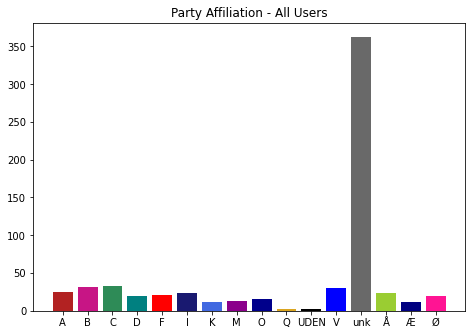

In [489]:
unique_list, count_list = unique_and_count(list(nx.get_node_attributes(G_visualize,'party').values()))
party_aff_plot(unique_list, count_list, "Party Affiliation - All Users", color_dict)

**Figure C.3.2.2:** Above plot shows the total amount of users with party affiliation.

In [490]:
all_parties = dict(zip(unique_list, count_list))
print(all_parties)

{'A': 25, 'B': 32, 'C': 33, 'D': 19, 'F': 21, 'I': 24, 'K': 11, 'M': 13, 'O': 16, 'Q': 2, 'UDEN': 2, 'V': 30, 'unk': 363, 'Å': 23, 'Æ': 12, 'Ø': 20}


**C.3.3 Visualizing TF-IDF Word Clouds for Top 16 Communities**

In this subsection, we compute TF-IDF word lists and make word clouds for these in the top 16 largest found communities. <br>
TF-IDF is short for Term Frequency - Inverse Document Frequency. It is a statistic that describes the importance of a word for a document while accounting for the relation to the rest of the documents from the corpus. Practically, this is done by counting the frequency of a word in a document while paying attention to the frequency of that same word in other documents in the same corpus.
- **TF**: We calculate TF by
$$TF(t,d) =  \log(1 + f(w,d))$$ <br><br>

- **IDF**: For IDF, we use:
$$IDF(w,D) = \log(\frac{N}{f(w,D)})$$  <br><br>
Finally, TF-IDF is computed by multipling TF with IDF: $$TFIDF = TF(t,d) \times IDF(w,D)$$ [6]

In [493]:
# Calculate TF
tf_tweets = pd.Series(comm_tweets).apply(nltk.FreqDist)

In [494]:
# Compute document frequency
d_freq = nltk.FreqDist(np.concatenate(pd.Series(comm_tweets).apply(lambda x: list(set(x))).values))

In [495]:
# Compute IDF
N = 16
idf_vals = np.log10(((1+N)/(1+np.array(list(d_freq.values()))))) + 1

In [496]:
idf = dict(zip(d_freq.keys(), idf_vals))

In [497]:
def tf_idf(tf, idf):
    """Compute TF-IDF
    """
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

In [498]:
series_TF_IDF = pd.Series(tf_tweets).apply(lambda x: tf_idf(x, idf))

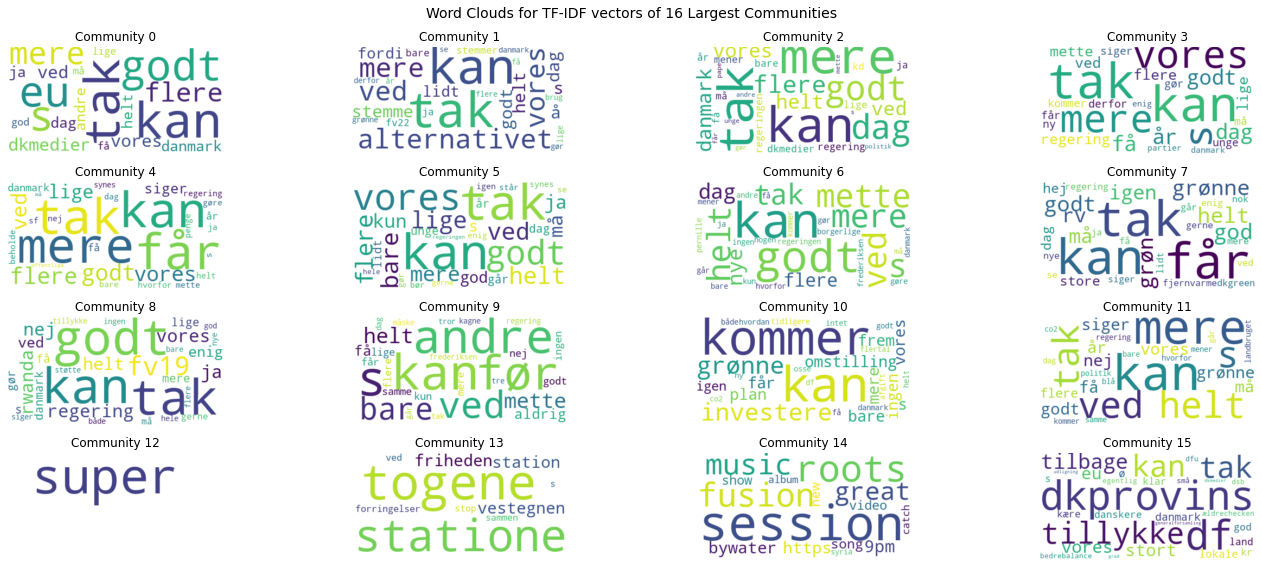

In [499]:
## Visualize TF-IDF wordclouds ##
fig, ax = plt.subplots(4, 4, figsize= (20, 8))

c = 0
for i in range(4):
    for j in range(4):
        w_list = sorted(series_TF_IDF[c], key=series_TF_IDF[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(w_list))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c}")
        c += 1
        
fig.suptitle("Word Clouds for TF-IDF vectors of 16 Largest Communities", fontsize = 14)
fig.tight_layout()
plt.show()

**Figure C.3.3.1:** Recall that before we found community 0, 3, 4, 5, 6, 8 and 10 to have a mixture of parties from different idiological sides. The wordclouds corresponding to these communities are dominated by words such as 'tak' (thanks), 'vores' (our) and 'danmark' (Denmark) which could indicate an absence of a hateful tone, at least among the tweets we scraped. We can also see that community 10 has a lot of words about sustainability, and that would suggest that parties from both sides of the political isle discuss this subject and that also reflects the political reality. Another topic discussed by both isles is the incumbent government led by PM Mette Frederiksen, which can be seen in Community 6. Community 14 is likely a community of bots mentioning the politicians, since these words are in English and are about music. Two communities that mainly consist of right-wing parties are Community 13 and 15. Inspecting the wordclouds, the top TF-IDF words for these also make sense, i.e., Community 14 includes the word "vestegnen" (Copenhagen West - an area used as an example by right-wing for increasing crime) and for Community 15; "lokale" (local - right-wing prides themselves in wanting to focus on the local citizen) and "dkprovins" (hashtag for the countryside - right-wing has decent support on the countryside).

**C.3.4 Visualizing Community in Network**

In [503]:
# Reorganizing partition into dict structure
par_class = set(part.values())
par_class_dict = {}

for v in part.values():
    str_v = str(v)
    
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [504]:
# Getting top 16, again
par_class_dict = {k: v for k, v in sorted(par_class_dict.items(), key=lambda item: item[1],reverse = True)}
par_name_top16 = list(par_class_dict.keys())[:16]

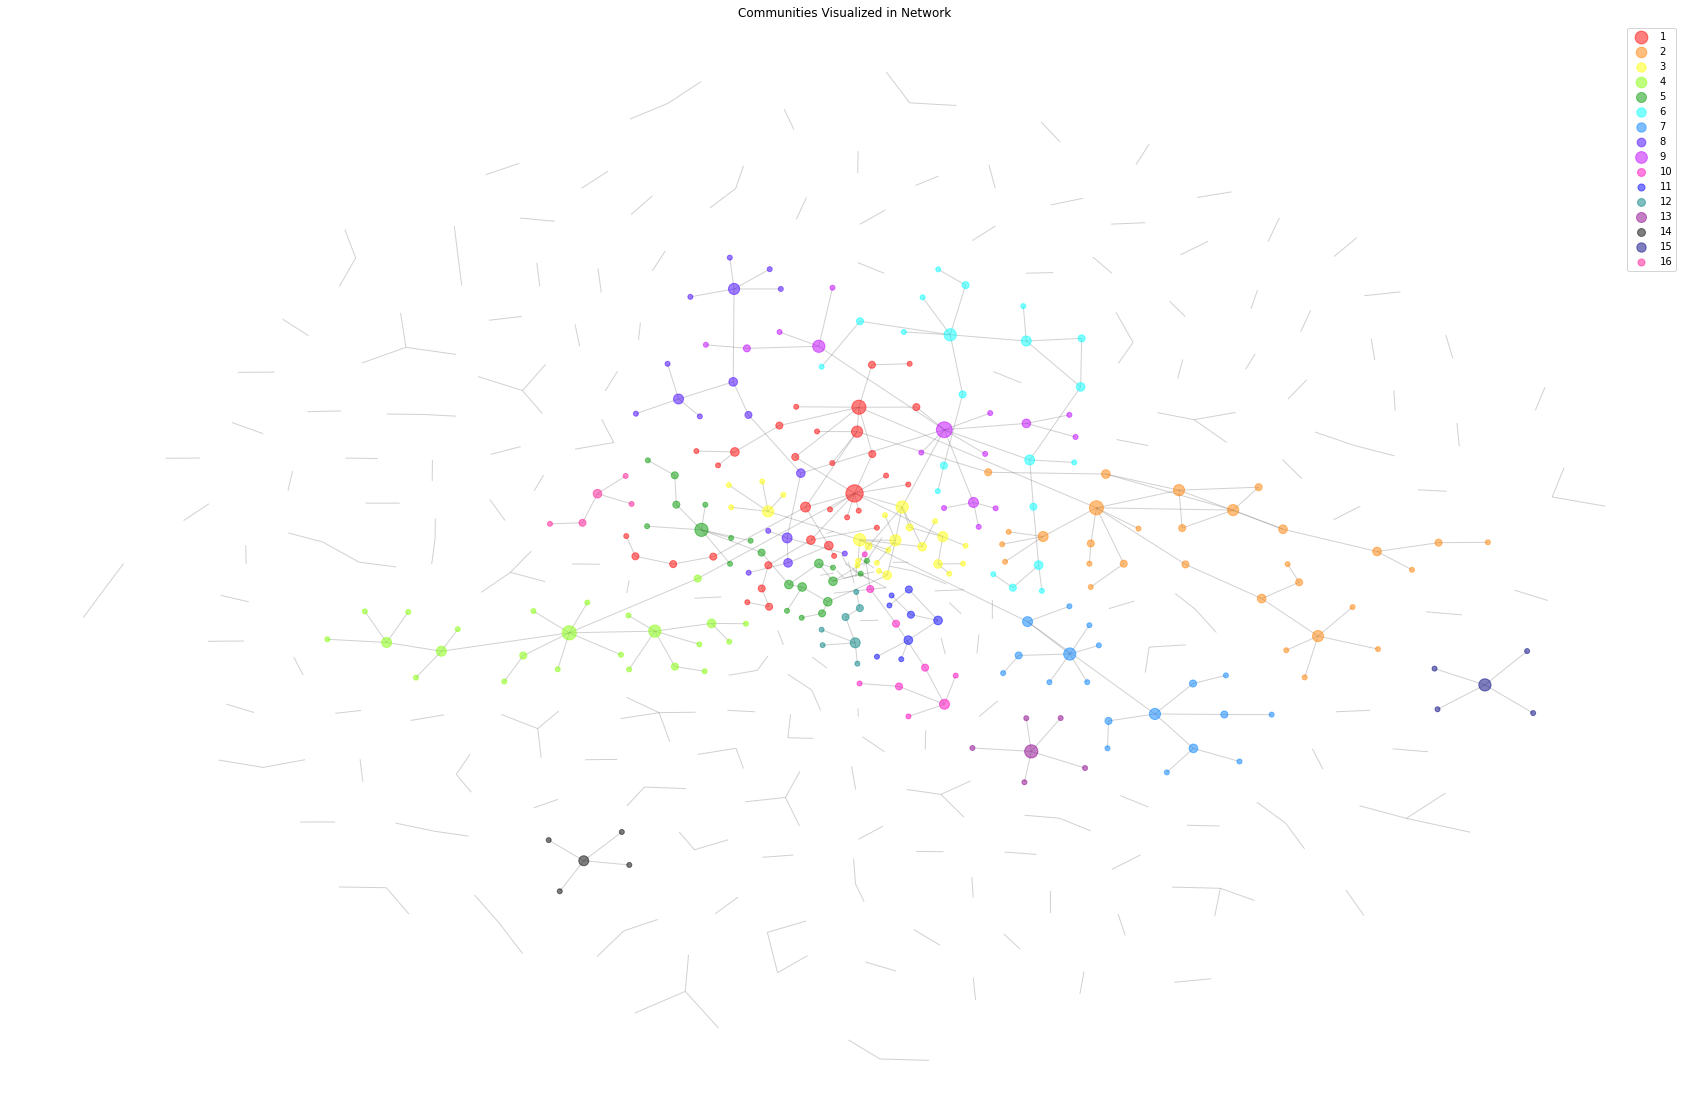

In [507]:
# Plot each community in network
plt.figure(figsize = (30,20))

nx.draw_networkx_edges(G_visualize,positions_full, alpha=0.3, edge_color = 'dimgray')

node_color_list = ['#ff0000','#ff8000','#ffff00','#80ff00',\
                   '#009900','#00ffff','#0080ff','#4000ff',\
                  '#bf00ff','#ff00bf', "blue", "teal", "darkmagenta", "black", "navy", "deeppink"]

for i,par_class in enumerate(par_name_top16):
    nodes = [n for n in list(G_visualize.nodes()) if part[n] == int(par_class)]
    d = dict(G_visualize.degree(nodes))
    nx.draw_networkx_nodes(G_visualize, positions_full, d.keys(), node_size=[v*25 for v in d.values()],
                       node_color=node_color_list[i],alpha = 0.5,label =i+1)

plt.legend()   
plt.axis('off')
plt.title("Communities Visualized in Network")
plt.show()   

**Figure C.3.4.1:** The identified communities plotted with the whole network. Only nodes in these top communities are displayed. Node-size is determined by the total degre of the node. 

## C.4 Identifying Central Users - Degree Centrality

In this section, central users in the network are identified using several centrality metrics. To compute the in-/out-degree centrality, we revert back to the directed version of the network graph.

In [508]:
# 5 most central characters according to degree centrality
in_degree_c = nx.in_degree_centrality(G)
out_degree_c = nx.out_degree_centrality(G)

# get the first 5 with in degree centrality
in_degree_c_sorted  = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (in degree centrality):\n{}'.format(in_degree_c_sorted[0:5]))
print('\n')

# get the first 5 with out degree centrality
out_degree_c_sorted  = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (out degree centrality):\n{}'.format(out_degree_c_sorted[0:5]))

5 most central users (in degree centrality):
[('alternativet_', 0.012403100775193798), ('KonservativeDK', 0.009302325581395349), ('venstredk', 0.009302325581395349), ('berlingske', 0.007751937984496124), ('metteabildgaard', 0.006201550387596899)]


5 most central users (out degree centrality):
[('MarleneAmbo', 0.018604651162790697), ('Scheelsbeck', 0.015503875968992248), ('AneHalsboe', 0.010852713178294573), ('hannebjornk', 0.009302325581395349), ('PLindhoutTravel', 0.009302325581395349)]


In [509]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

out_deg_A = []
out_deg_B = []
out_deg_C = []
out_deg_D = []
out_deg_F = []
out_deg_I = []
out_deg_K = []
out_deg_M = []
out_deg_O = []
out_deg_Q = []
out_deg_V = []
out_deg_Æ = []
out_deg_Ø = []
out_deg_Å = []
out_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(in_degree_c[node])
        out_deg_A.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(in_degree_c[node])
        out_deg_B.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(in_degree_c[node])
        out_deg_C.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(in_degree_c[node])
        out_deg_D.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(in_degree_c[node])
        out_deg_F.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(in_degree_c[node])
        out_deg_I.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(in_degree_c[node])
        out_deg_K.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(in_degree_c[node])
        out_deg_M.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(in_degree_c[node])
        out_deg_O.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(in_degree_c[node])
        out_deg_Q.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(in_degree_c[node])
        out_deg_V.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(in_degree_c[node])
        out_deg_Æ.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(in_degree_c[node])
        out_deg_Ø.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(in_degree_c[node])
        out_deg_Å.append(out_degree_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(in_degree_c[node])
        out_deg_UDEN.append(out_degree_c[node])

  0%|          | 0/646 [00:00<?, ?it/s]

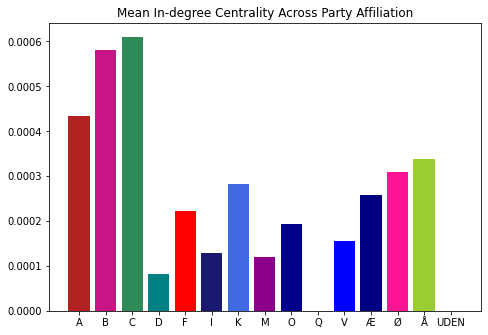

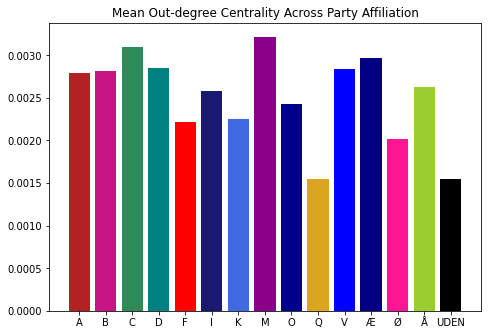

In [510]:
party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean In-degree Centrality Across Party Affiliation",color_dict_)
party_aff_plot(unique_parties_lst, [np.mean(out_deg_A), np.mean(out_deg_B), np.mean(out_deg_C), np.mean(out_deg_D), np.mean(out_deg_F), np.mean(out_deg_I), np.mean(out_deg_K), np.mean(out_deg_M), np.mean(out_deg_O), np.mean(out_deg_Q), np.mean(out_deg_V), np.mean(out_deg_Æ), np.mean(out_deg_Ø), np.mean(out_deg_Å), np.mean(out_deg_UDEN)], "Mean Out-degree Centrality Across Party Affiliation",color_dict_)

**Figure C.4.1:** Above plots display the mean in-/out-degree centrality for users of different parties. These two plots are, unsurprisingly, identical to the ones showing the mean in-/out-degree, since in-/out-degree centrality is defined using the number of in-/out-edges of a node.

In [512]:
def plot_force_directed_graph(Graph, node_size_dict, fivemost_nodes, title_text, node_scale):
    """Make Force Atlas 2 directed graph plot of network with five most central nodes plotted.

        Args:
            Graph (NetworkX Graph object): NetworkX graph to plot.
            node_size_dict (dict): Dictionary of all nodes with value as node size and key for node name.
            fivemost_nodes (dict): Dictionary of five most central nodes with value as node size and key for node name.
            title_text (str): Title for plot.
            node_scale (int): Scaling factor for plotting the nodes.

    """
    # Get color maps from color_maps() function
    color_map_nodes, color_map_edge, degree_dict = color_maps(Graph, pol_spec = False)
    
    plt.figure(figsize = (30,20))

    forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False,  # Dissuation
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0, # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(Graph, pos=None, iterations=2000)
    
    nx.draw_networkx(Graph, positions_full,nodelist=list(node_size_dict.keys()), node_size=[v * node_scale for v in node_size_dict.values()], alpha = 0.6,\
                        node_color = color_map_nodes,edge_color = color_map_edge,with_labels=False)
    
    nx.draw_networkx_nodes(Graph, positions_full, nodelist=list(fivemost_nodes.keys()),node_size=[v * node_scale for v in fivemost_nodes.values()], \
                           alpha = 1, node_color="#EA3C0D",edgecolors ='black')
    labels = {}
    for node in fivemost_nodes.keys():
        labels[node] = node
    
    nx.draw_networkx_labels(Graph,positions_full,labels,font_size=18,font_color='k')
    
    plt.title(title_text,fontsize=28)
    plt.axis('off')
    plt.legend(handles = handles_dict)
    plt.show()

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 115.21it/s]


BarnesHut Approximation  took  3.14  seconds
Repulsion forces  took  13.38  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.43  seconds


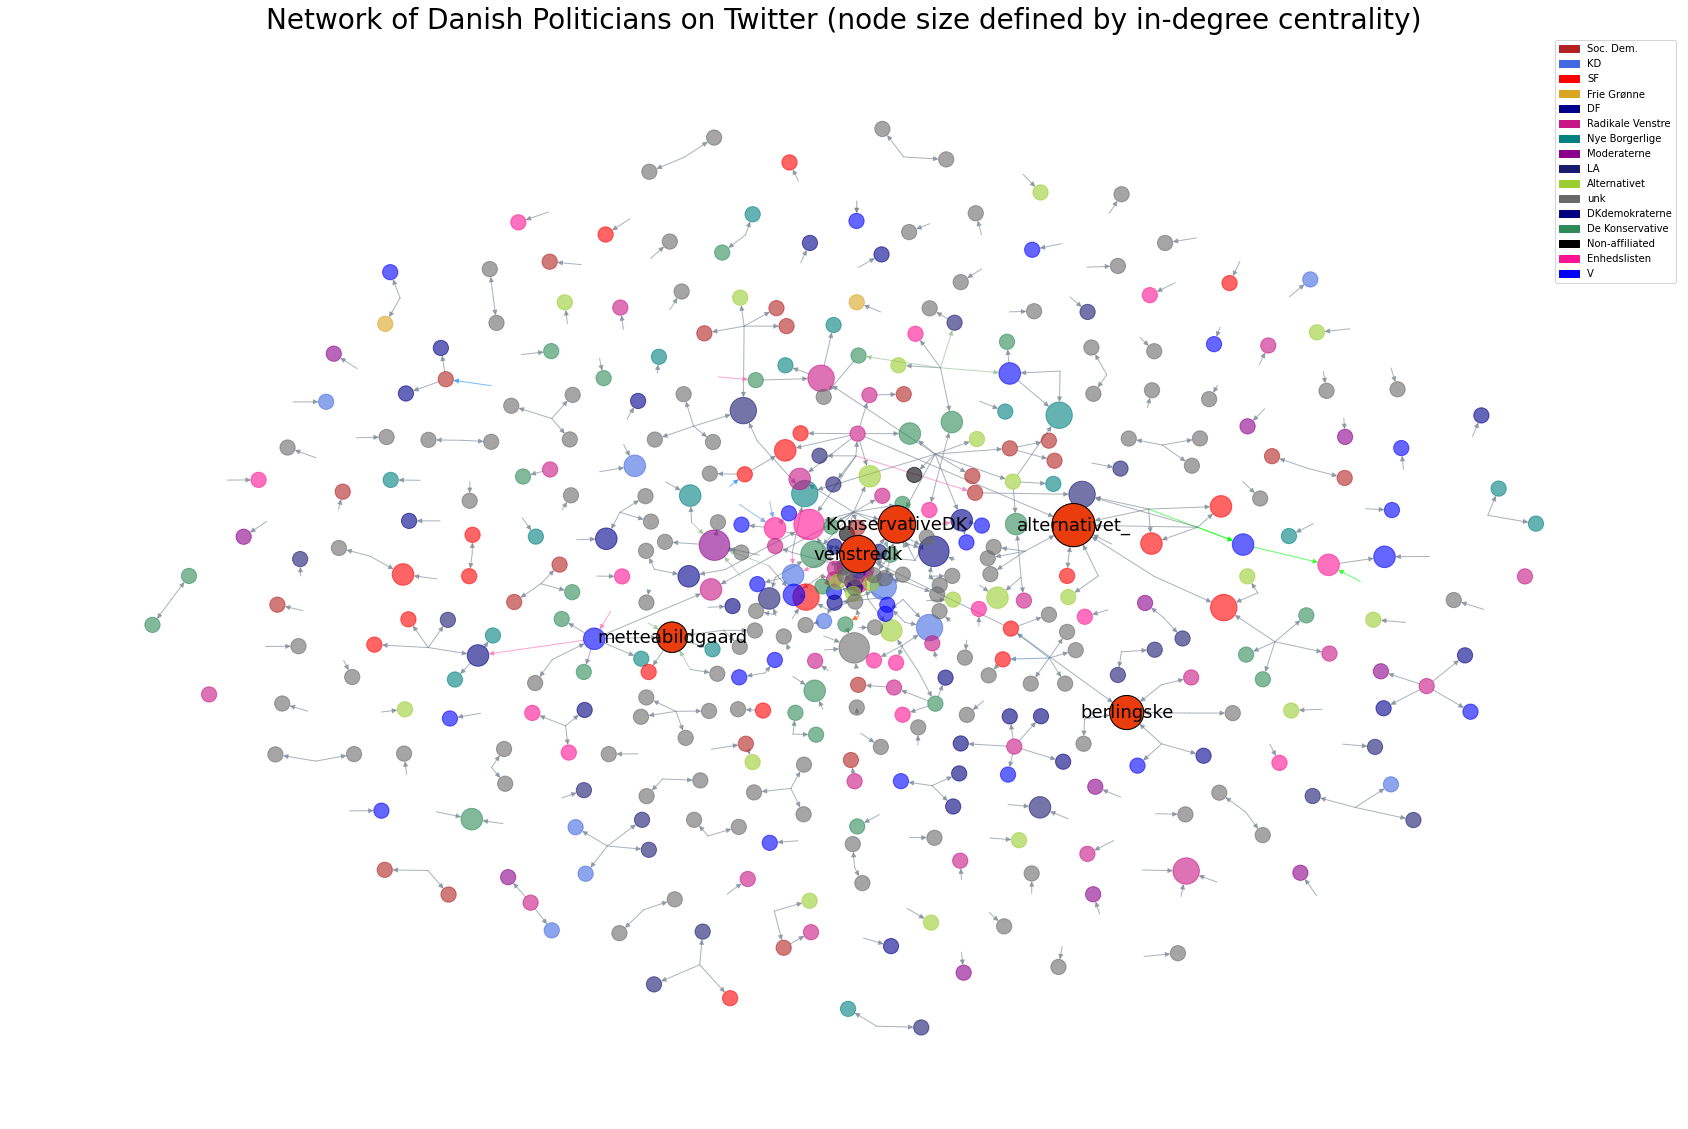

In [513]:
# Plot the network with in-degree centrality
in_degree_c_sorted = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
in_degree_c_sorted = dict(in_degree_c_sorted)
in_degree_c_sorted.update((x, y*10000) for x, y in in_degree_c_sorted.items())

# 5 most central users according to in-degree
nodes_ = list(in_degree_c_sorted)[0:5]
fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_degree_c_sorted[i]

title_text = 'Network of Danish Politicians on Twitter (node size defined by in-degree centrality)'

plot_force_directed_graph(G, in_degree_c_sorted,fivemost_nodes,title_text, 15)

**Figure C.4.2:** The five most central users according to in-degree centrality are plotted in the whole network above, along with the rest of the users colored according to party affiliation.  Node-size is determined by the in-degree centrality of the node.

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 113.07it/s]


BarnesHut Approximation  took  2.96  seconds
Repulsion forces  took  13.82  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.39  seconds


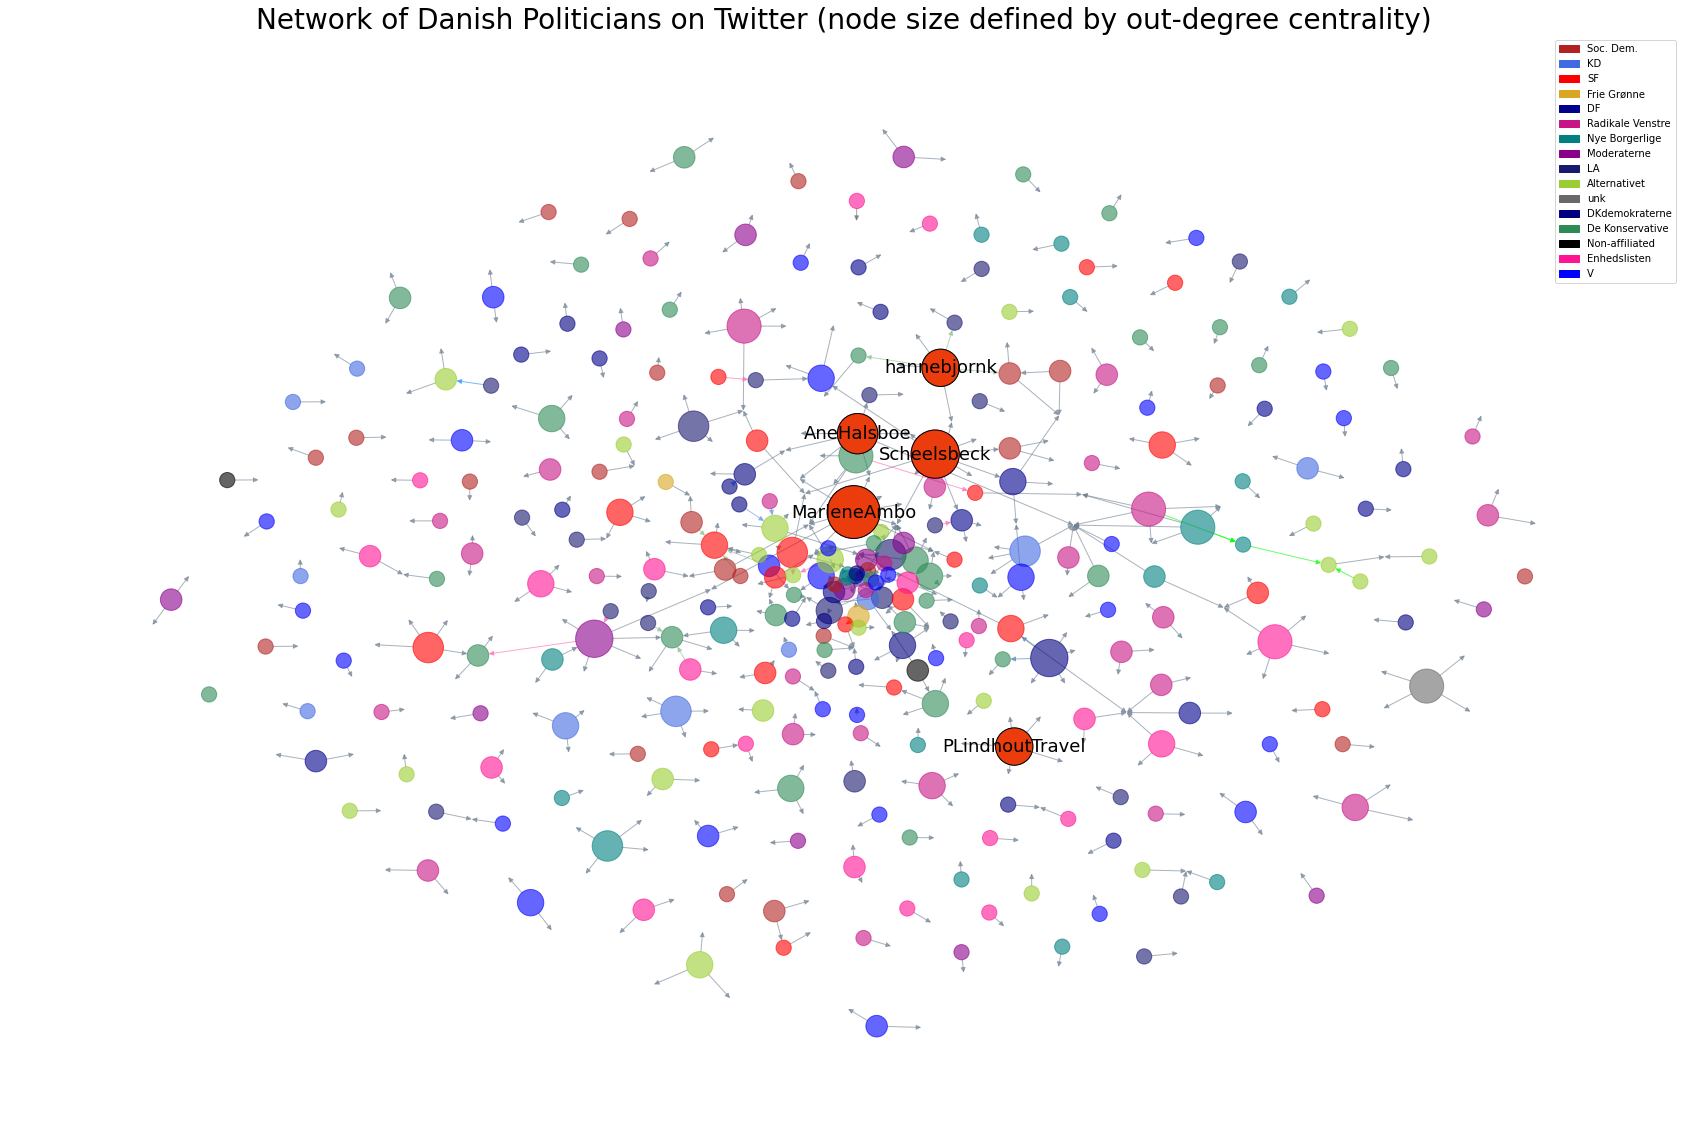

In [514]:
# Plot the network with out-degree centrality
out_degree_c_sorted = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
out_degree_c_sorted = dict(out_degree_c_sorted)
out_degree_c_sorted.update((x, y*10000) for x, y in out_degree_c_sorted.items())

# 5 most central users according to out-degree
nodes_ = list(out_degree_c_sorted)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_degree_c_sorted[i]

title_text = 'Network of Danish Politicians on Twitter (node size defined by out-degree centrality)'

plot_force_directed_graph(G, out_degree_c_sorted,fivemost_nodes,title_text, 15)

**Figure C.4.3:** The five most central users according to out-degree centrality are plotted in the whole network above, along with the rest of the users colored according to party affiliatin. Node-size is determined by the out-degree centrality of the node.

**C.4.1 Betweenness Centrality for Undirected Graph**

In betweenness centrality, the more times a node is in the shortest path between two other nodes, the more central it is [4]. Label each edge $e=\{u, v\} \in E(G)$ with a score $b(e)$. Define:
$$
b(e)=\sum_{\substack{x, y \in V(G) \\ x \neq y}} \frac{\# \text { shortest } x-y \text { paths that use e }}{\# \text { all shortest } x-y \text { paths }}
$$

To compute the betweenness centrality we use the undirected version of the graph:

In [515]:
between_c = nx.betweenness_centrality(G_visualize)

In [516]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(between_c[node])

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(between_c[node])

  0%|          | 0/646 [00:00<?, ?it/s]

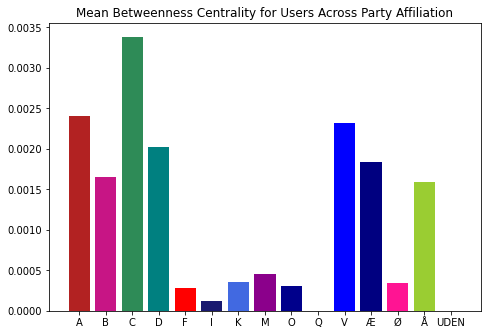

In [517]:
party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean Betweenness Centrality for Users Across Party Affiliation",color_dict_)

**Figure C.4.1.1:** Above plot displays the mean betweenness centrality for users of different parties. 

In [518]:
# the 5 most central characters according to betweenness centrality
bet_c_sorted  = sorted(between_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central characters (betweenness centrality):\n{}'.format(bet_c_sorted[0:5]))
print('\n')

5 most central characters (betweenness centrality):
[('KonservativeDK', 0.0529945270996838), ('Scheelsbeck', 0.04526152759722021), ('MarleneAmbo', 0.04521105172773526), ('PernilleVermund', 0.03152294284751312), ('AneHalsboe', 0.030662686375527617)]




In [519]:
# Scale for better plotting
bet_c_sorted = dict(bet_c_sorted)
bet_c_sorted.update((x, y*100000) for x, y in between_c.items())

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:16<00:00, 119.74it/s]


BarnesHut Approximation  took  3.29  seconds
Repulsion forces  took  12.58  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.42  seconds


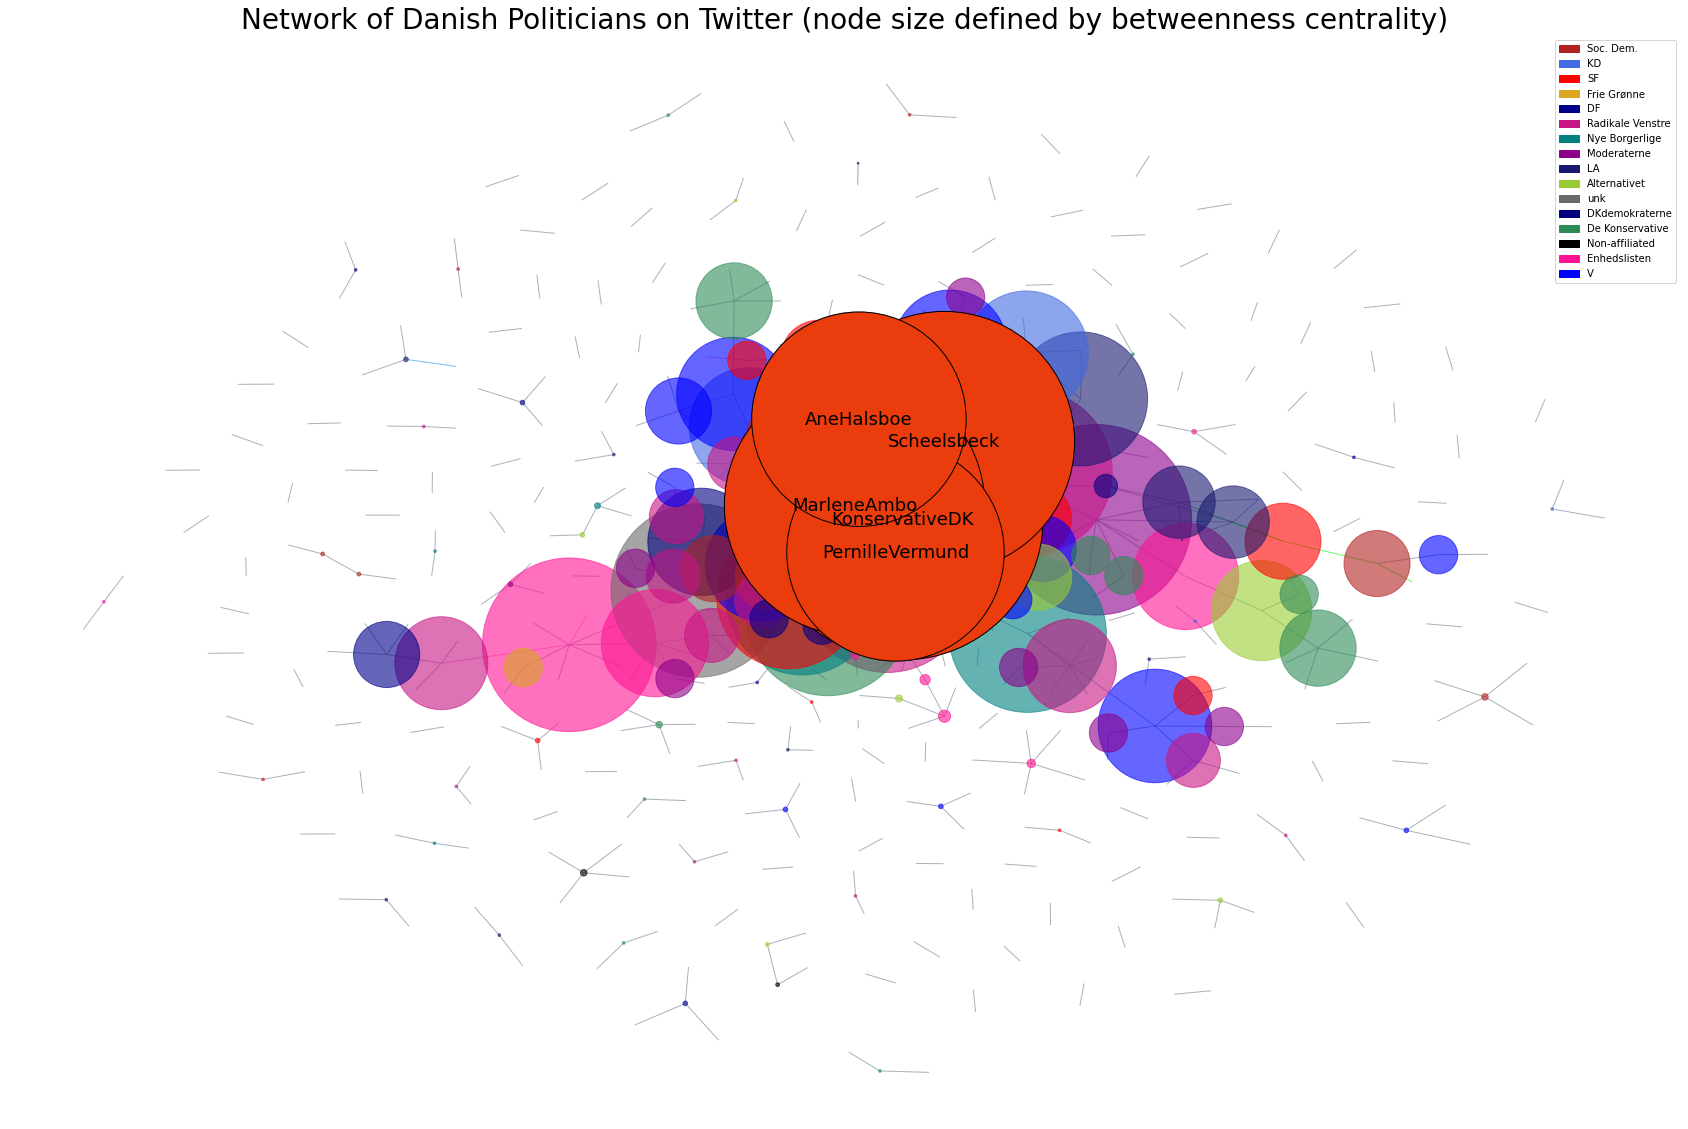

In [520]:
# 5 most central users
nodes_ = list(bet_c_sorted)[0:5]
fivemost_nodes = {}

for i in nodes_:
    fivemost_nodes[i] = bet_c_sorted[i]

plot_force_directed_graph(G_visualize, bet_c_sorted, fivemost_nodes,\
                          'Network of Danish Politicians on Twitter (node size defined by betweenness centrality)', 15)

**Figure C.4.1.2:** The five most central users according to betweenness centrality are plotted in the whole network above, along with the rest of the users colored according to party affiliatin. Node-size is determined by the betweenness centrality of the node.

**C.4.2 Eigenvector Centrality**

Another measure of node influce in an network is eigenvector centrality. The algorithm measures the transitive influence of nodes [3].

In [521]:
## Compute eigenvector centrality for in- and out-edges ##

# In-degree edges
in_eigen_c_ = nx.eigenvector_centrality(G)

# Out-degree edges
out_eigen_c_ = nx.eigenvector_centrality(G.reverse())

# sort both eigenvector centrality
in_eigen_c = sorted(in_eigen_c_.items(),key = lambda x:x[1],reverse = True)
out_eigen_c = sorted(out_eigen_c_.items(),key = lambda x:x[1],reverse = True)

# get the 5 most central characters according to eigenvector centrality
print('5 most central users (eigenvector centrality corresponding to in-edges):\n{}'.format(in_eigen_c[0:5]))
print(" ")
print('5 most central users (eigenvector centrality corresponding to out-edges):\n{}'.format(out_eigen_c[0:5]))

5 most central users (eigenvector centrality corresponding to in-edges):
[('RosaLundEl', 0.478092436720301), ('Kvinderaadet', 0.4780901285004536), ('JinoVDoabi', 0.4780901285004536), ('Halime9Oguz', 0.11952315726798882), ('jobywatermusic', 0.11952315726798882)]
 
5 most central users (eigenvector centrality corresponding to out-edges):
[('PLindhoutTravel', 0.5477203659306094), ('jobywatermusic', 0.4564336400892131), ('Scheelsbeck', 0.27388121286904105), ('Halime9Oguz', 0.2738601884064186), ('RosaLundEl', 0.2738601884064186)]


In [522]:
in_deg_A = []
in_deg_B = []
in_deg_C = []
in_deg_D = []
in_deg_F = []
in_deg_I = []
in_deg_K = []
in_deg_M = []
in_deg_O = []
in_deg_Q = []
in_deg_V = []
in_deg_Æ = []
in_deg_Ø = []
in_deg_Å = []
in_deg_UDEN = []

out_deg_A = []
out_deg_B = []
out_deg_C = []
out_deg_D = []
out_deg_F = []
out_deg_I = []
out_deg_K = []
out_deg_M = []
out_deg_O = []
out_deg_Q = []
out_deg_V = []
out_deg_Æ = []
out_deg_Ø = []
out_deg_Å = []
out_deg_UDEN = []

# Define colors for all parties
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'A': # Soc. Dem.
        in_deg_A.append(in_eigen_c_[node])
        out_deg_A.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'B': # Radikale venstre
        in_deg_B.append(in_eigen_c_[node])
        out_deg_B.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'C': # Konservative
        in_deg_C.append(in_eigen_c_[node])
        out_deg_C.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'D': # Nye Borgerlige
        in_deg_D.append(in_eigen_c_[node])
        out_deg_D.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'F': # SF
        in_deg_F.append(in_eigen_c_[node])
        out_deg_F.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'I': # LA
        in_deg_I.append(in_eigen_c_[node])
        out_deg_I.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'K': # KD
        in_deg_K.append(in_eigen_c_[node])
        out_deg_K.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'M': # Moderaterne
        in_deg_M.append(in_eigen_c_[node])
        out_deg_M.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'O': # DF
        in_deg_O.append(in_eigen_c_[node])
        out_deg_O.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Q': # Frie grønne
        in_deg_Q.append(in_eigen_c_[node])
        out_deg_Q.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'V': # Venstre
        in_deg_V.append(in_eigen_c_[node])
        out_deg_V.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Æ': # DK demokraterne
        in_deg_Æ.append(in_eigen_c_[node])
        out_deg_Æ.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Ø': # Enhedslisten
        in_deg_Ø.append(in_eigen_c_[node])
        out_deg_Ø.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'Å': # Alternativet
        in_deg_Å.append(in_eigen_c_[node])
        out_deg_Å.append(out_eigen_c_[node])

    elif nx.get_node_attributes(G,'party')[node] == 'UDEN':
        in_deg_UDEN.append(in_eigen_c_[node])
        out_deg_UDEN.append(out_eigen_c_[node])

  0%|          | 0/646 [00:00<?, ?it/s]

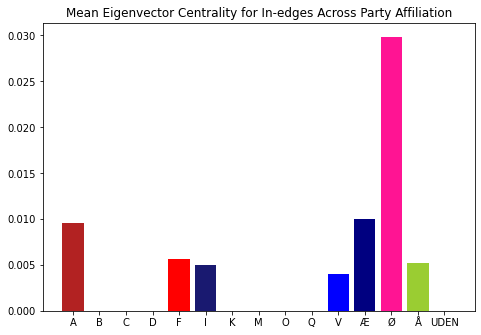

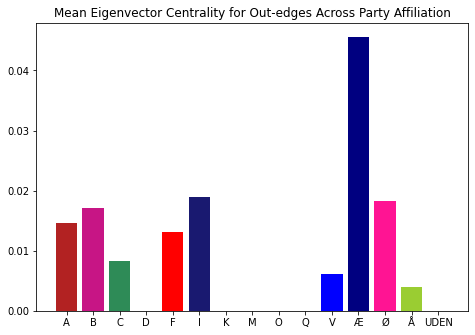

In [523]:
party_aff_plot(unique_parties_lst, [np.mean(in_deg_A), np.mean(in_deg_B), np.mean(in_deg_C), np.mean(in_deg_D), np.mean(in_deg_F), np.mean(in_deg_I), np.mean(in_deg_K), np.mean(in_deg_M), np.mean(in_deg_O), np.mean(in_deg_Q), np.mean(in_deg_V), np.mean(in_deg_Æ), np.mean(in_deg_Ø), np.mean(in_deg_Å), np.mean(in_deg_UDEN)], "Mean Eigenvector Centrality for In-edges Across Party Affiliation",color_dict_)
party_aff_plot(unique_parties_lst, [np.mean(out_deg_A), np.mean(out_deg_B), np.mean(out_deg_C), np.mean(out_deg_D), np.mean(out_deg_F), np.mean(out_deg_I), np.mean(out_deg_K), np.mean(out_deg_M), np.mean(out_deg_O), np.mean(out_deg_Q), np.mean(out_deg_V), np.mean(out_deg_Æ), np.mean(out_deg_Ø), np.mean(out_deg_Å), np.mean(out_deg_UDEN)], "Mean Eigenvector Centrality for Out-edges Across Party Affiliation",color_dict_)

**Figure C.4.2.1:** Above plots display the mean eigenvector centrality for in-/out-edges for users of different parties.

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 116.10it/s]


BarnesHut Approximation  took  3.31  seconds
Repulsion forces  took  13.11  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


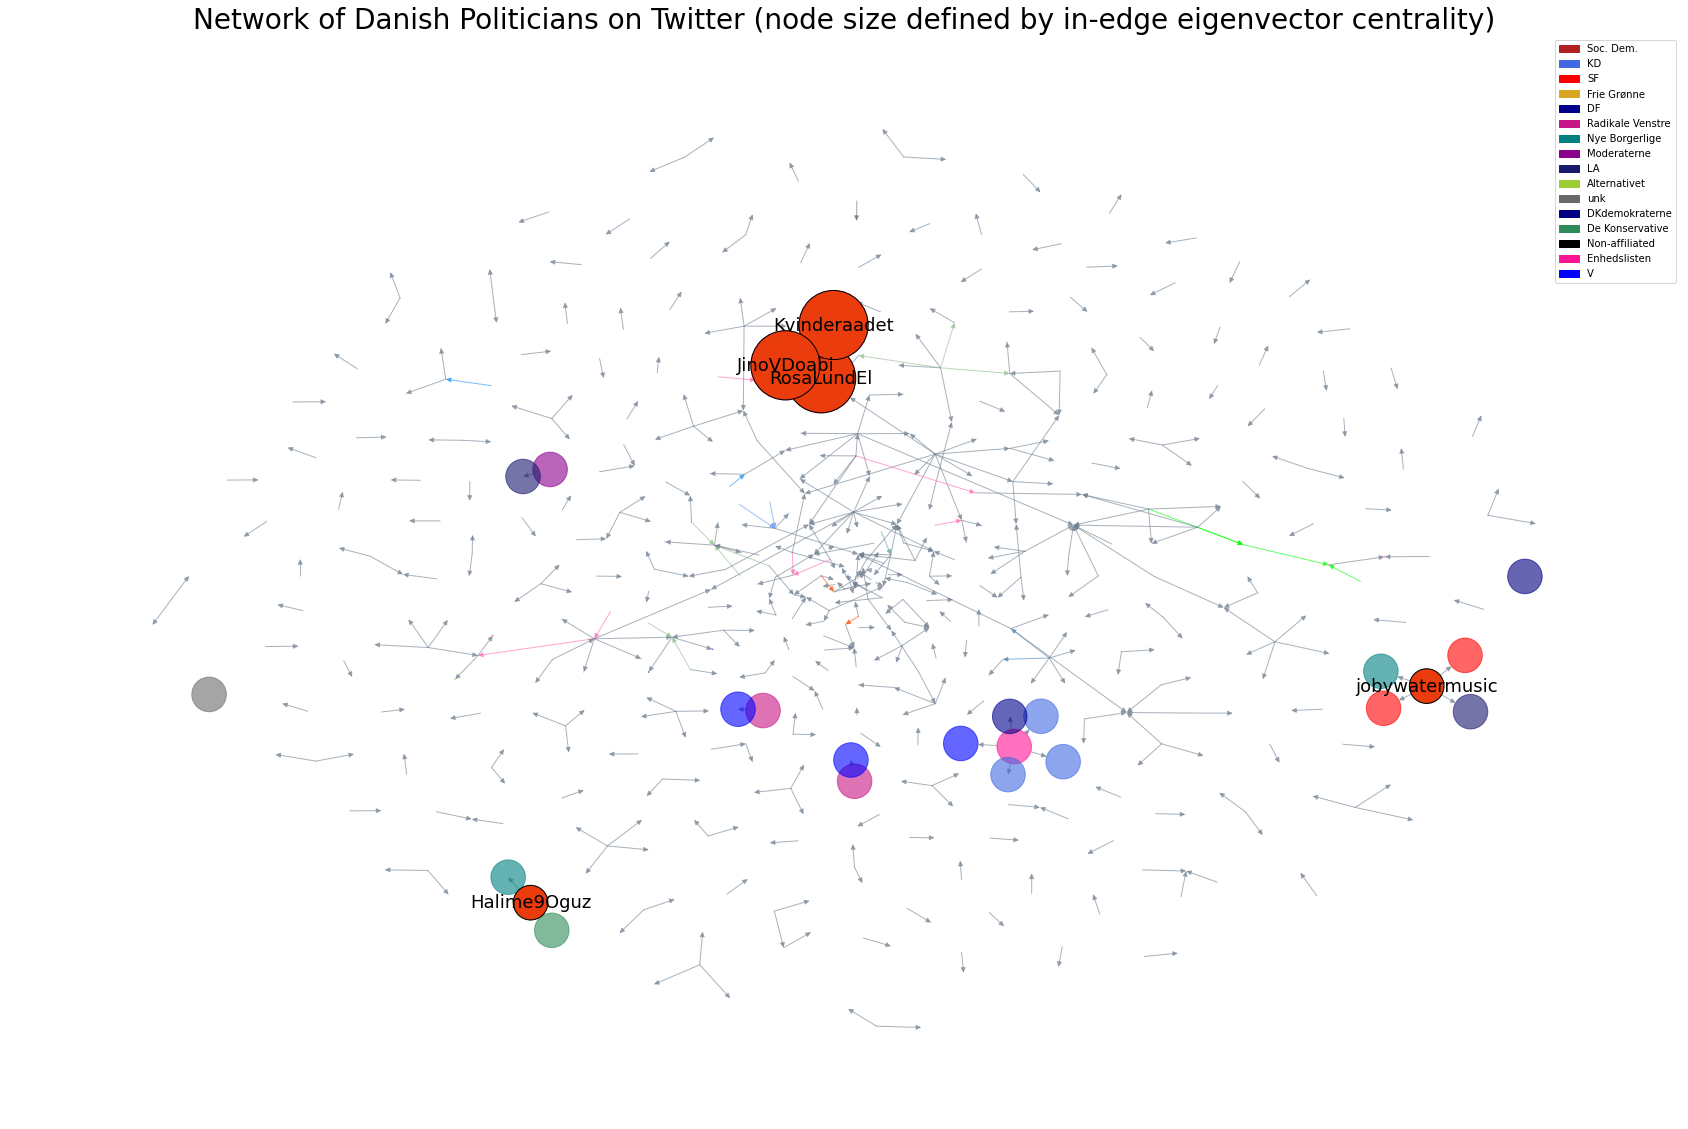

In [524]:
# Scale for better plotting
in_eigen_c_plot = dict(in_eigen_c)
in_eigen_c_plot.update((x, y*10000) for x, y in in_eigen_c_plot.items())

# Take top five
nodes_ = list(in_eigen_c_plot)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_eigen_c_plot[i]
    
plot_force_directed_graph(G, in_eigen_c_plot,fivemost_nodes,\
                          'Network of Danish Politicians on Twitter (node size defined by in-edge eigenvector centrality)', 1)

**Figure C.4.2.2:** The five most central users according to in-edge eigenvector centrality are plotted in the whole network above, along with the rest of the users colored according to party affiliation.

  0%|          | 0/646 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:17<00:00, 116.50it/s]


BarnesHut Approximation  took  3.02  seconds
Repulsion forces  took  13.32  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.43  seconds


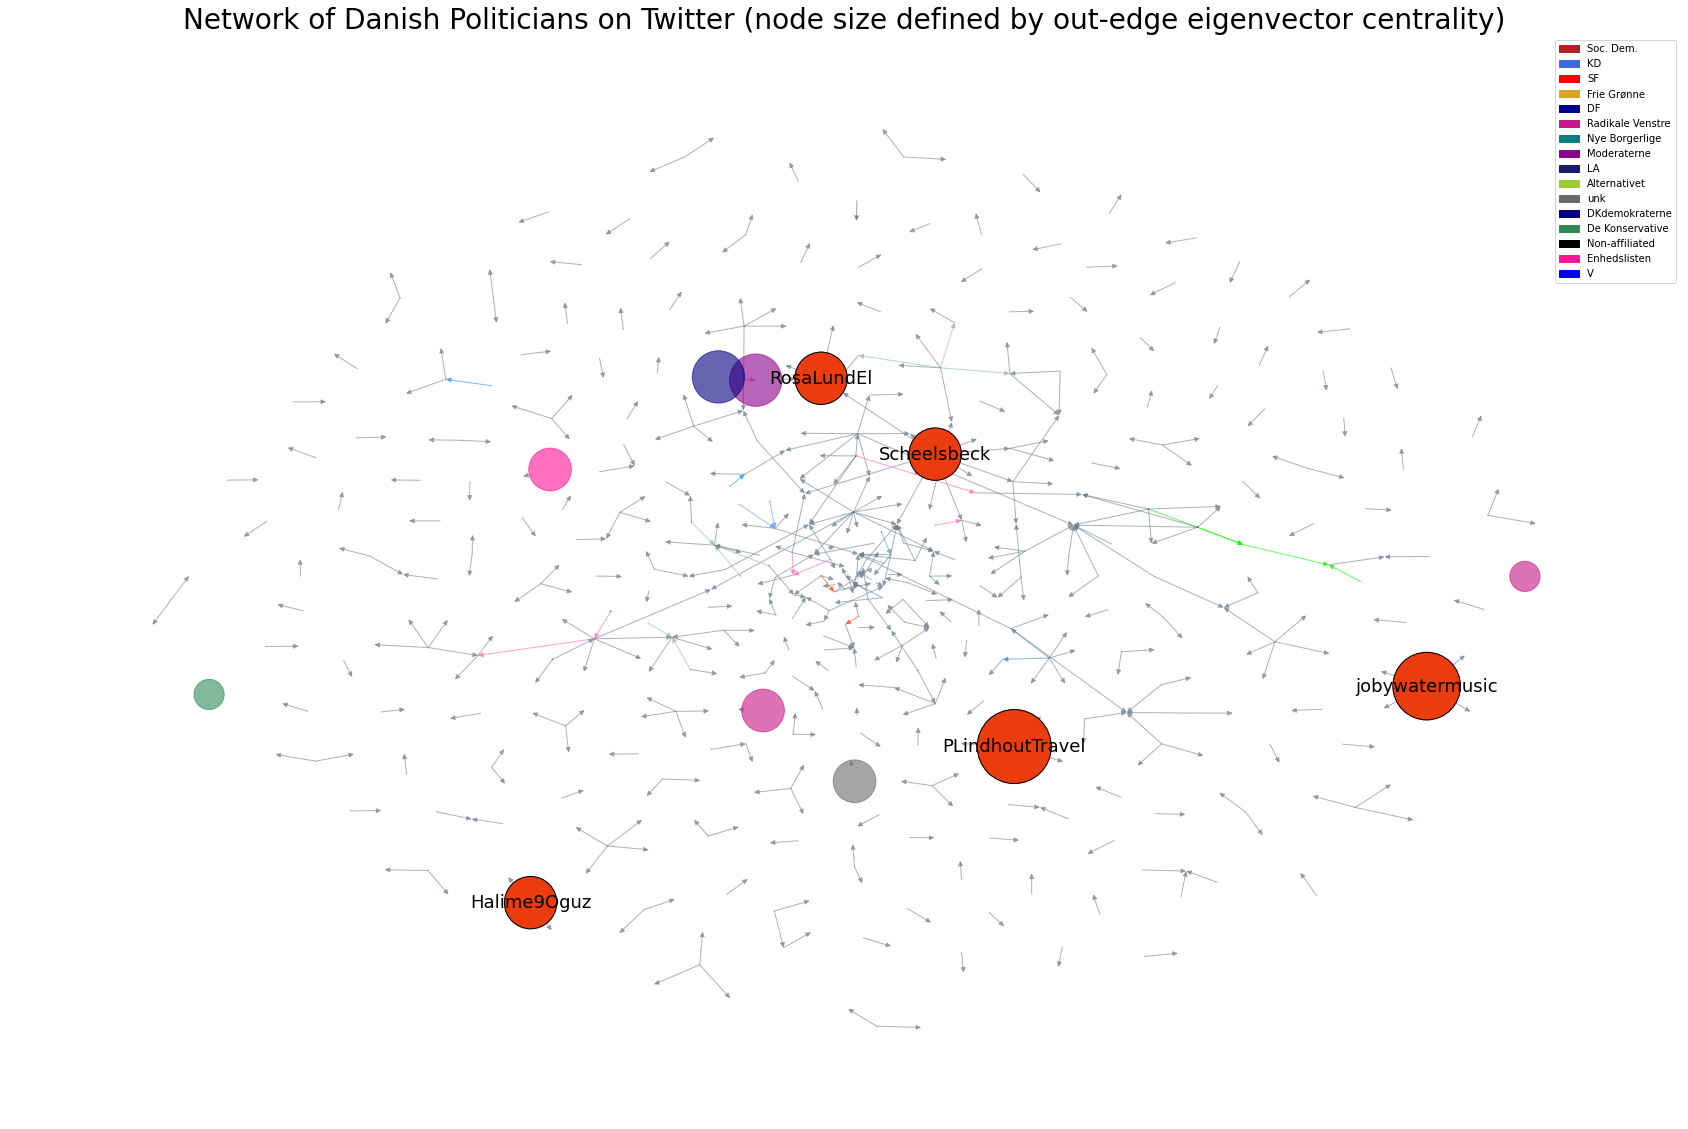

In [525]:
# Scaling for better plot
out_eigen_c_plot = dict(out_eigen_c)
out_eigen_c_plot.update((x, y*10000) for x, y in out_eigen_c_plot.items())

# Grab top five nodes with highest out-edge eigenvector centrality
nodes_ = list(out_eigen_c_plot)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_eigen_c_plot[i]

plot_force_directed_graph(G, out_eigen_c_plot,fivemost_nodes,\
                          'Network of Danish Politicians on Twitter (node size defined by out-edge eigenvector centrality)', 1)

**Figure C.4.2.3:** The five most central users according to out-edge eigenvector centrality are plotted in the whole network above, along with the rest of the users colored according to party affiliation.

**C.4.3 Assortativity wrt. Degree**

In this subsection we attempt to answer the question; do high-degree users tend to link with other high-degree users?

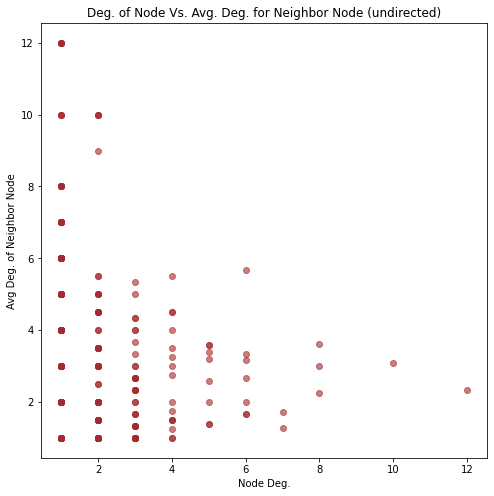

In [526]:
avg_neigh_degrees = nx.average_neighbor_degree(G_visualize)

# plot
plt.figure(figsize=(8,8))
plt.scatter(dict(G_visualize.degree()).values(),avg_neigh_degrees.values(),c= 'brown',alpha=0.6)
plt.title('Deg. of Node Vs. Avg. Deg. for Neighbor Node (undirected)')
plt.xlabel('Node Deg.')
plt.ylabel('Avg Deg. of Neighbor Node')
plt.show()

**Figure C.4.3.1:** From the plot it is evident that high-degree users do not tend to link with low-degree users.

## C.5 Results with 'unk' Users Removed

In this section we build the network again, but this time without the 'unk' users; so that it only contains the candidates for the election.

In [527]:
## Removal of 'unk' users ##
unks = []
for node in tqdm(list(G.nodes())):
    if nx.get_node_attributes(G,'party')[node] == 'unk':
        unks.append(node)

G.remove_nodes_from(unks)


  0%|          | 0/646 [00:00<?, ?it/s]

In [528]:
print("Number of edges:")
len(G.edges)

Number of edges:


57

In [529]:
print("Number of Nodes:")
len(G.nodes)

Number of Nodes:


283

**C.5.1 Check in/out-degree:**

In [530]:
# In-degrees
tuples_in_deg = G.in_degree(G.nodes())
in_deg = [x[1] for x in tuples_in_deg] 

# Out-degrees
tuples_out_deg = G.out_degree(G.nodes())
out_deg = [x[1] for x in tuples_out_deg] 

print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_deg),min(in_deg), np.median(in_deg)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_deg),min(out_deg),np.median(out_deg)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_deg if i >5])))


In degree	max: 4	min: 0	median: 0.0
Out degree	max: 4	min: 0	median: 0.0
Nodes with in-degree larger than 100: 0


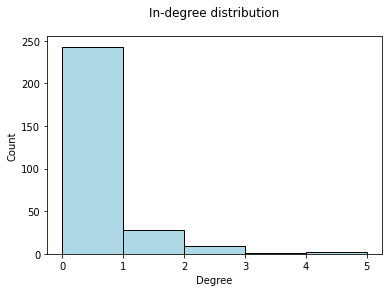

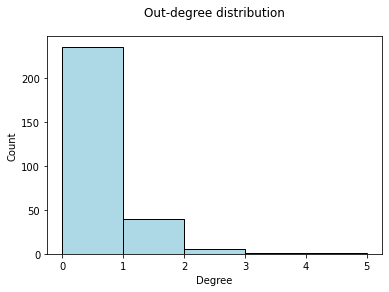

In [531]:
## Plot degree distributions
plt.title("In-degree distribution",pad = 20.0)
plt.hist(in_deg, bins = np.arange(np.min(in_deg), np.max(in_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

plt.title("Out-degree distribution",pad = 20.0)
plt.hist(out_deg, bins = np.arange(np.min(out_deg), np.max(out_deg)+2), color = 'lightblue', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

**Figure C.5.1.1:** Histograms of degree distributions.

In [533]:
## Most connected users
in_deg_dict = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(in_deg_dict, key=in_deg_dict.get, reverse=True)[:20])

out_deg_dict = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(out_deg_dict, key=out_deg_dict.get, reverse=True)[:10])

Top most in-degree connected users: , ['metteabildgaard', 'SorenPape', 'RosaLundEl', 'rasmushelveg', 'sofiecn', 'PHummelgaard', 'Ammitzboell_K', 'TScavenius', 'martinlidegaard', 'JacobNetteberg', 'StigGrenov', 'TorstenGejl', 'khoenge', 'JThulesen', 'RasmusJarlov', 'MrMesserschmidt', 'mettereissmann', 'carolinamaier', 'ThomasRohden', 'Halime9Oguz']
Top most out-degree connected users: , ['Scheelsbeck', 'hannebjornk', 'brittbager', 'ViviNoer', 'AmdiBurgess', 'martinlidegaard', 'ThDanielsen', 'UllaKokfelt', 'JohnnieVG', 'lars_aslan']


**C.5.2 Visualizing Network**

In [534]:
# Convert to undirected graph for visualization purposes (so we do not end up with a lot of arrows)
G_visualize = G.to_undirected()

color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = False)

  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:06<00:00, 322.02it/s]


BarnesHut Approximation  took  0.97  seconds
Repulsion forces  took  4.90  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


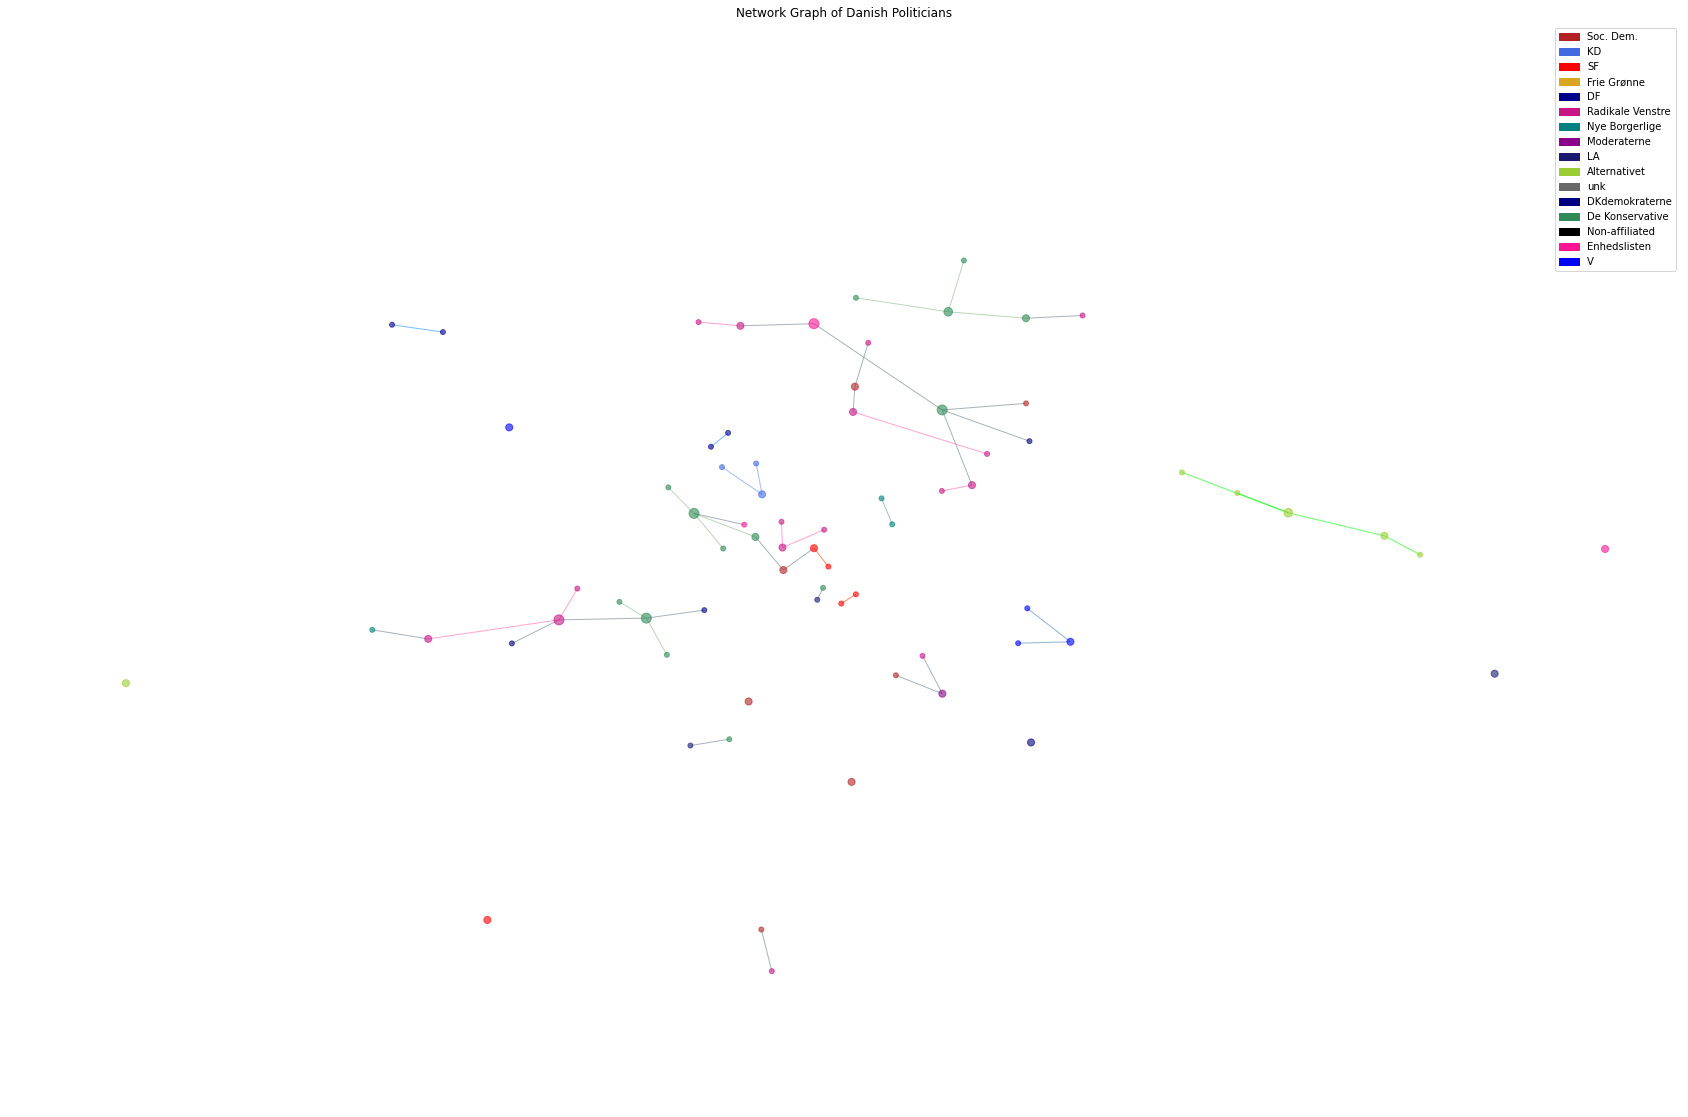

In [536]:
## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions_full,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict)
plt.show()

**Figure C.5.2.1:** The network of Danish parliamentary candidates on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to party affiliation. With the 'unk' users removed, we can see that the network is now much more sparse with fewer nodes and connections overall.

In [537]:
# Extract largest component
gcc = max(nx.weakly_connected_components(G), key=len)
gcc_subgraph = G.subgraph(gcc)
gcc_visualize = gcc_subgraph.to_undirected()

color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = False)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 39972.97it/s]


BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


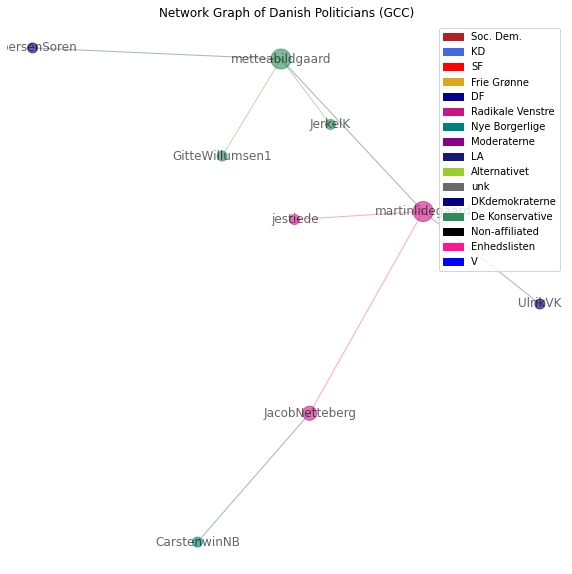

In [538]:
## Plotting network (GCC) ##
plt.figure(figsize = (10,10))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions_gcc,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=True)

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict)
plt.show()

**Figure C.5.2.2:** The greatest connected component in the network of Danish parliamentary candidates on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to party affiliation.

In [539]:
print("Number of nodes in GCC:")
print(len(gcc_visualize.nodes))

Number of nodes in GCC:
9


In [540]:
print("Number of edges in GCC:")
print(len(gcc_visualize.edges))

Number of edges in GCC:
8


  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:06<00:00, 307.64it/s]


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  5.14  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.22  seconds


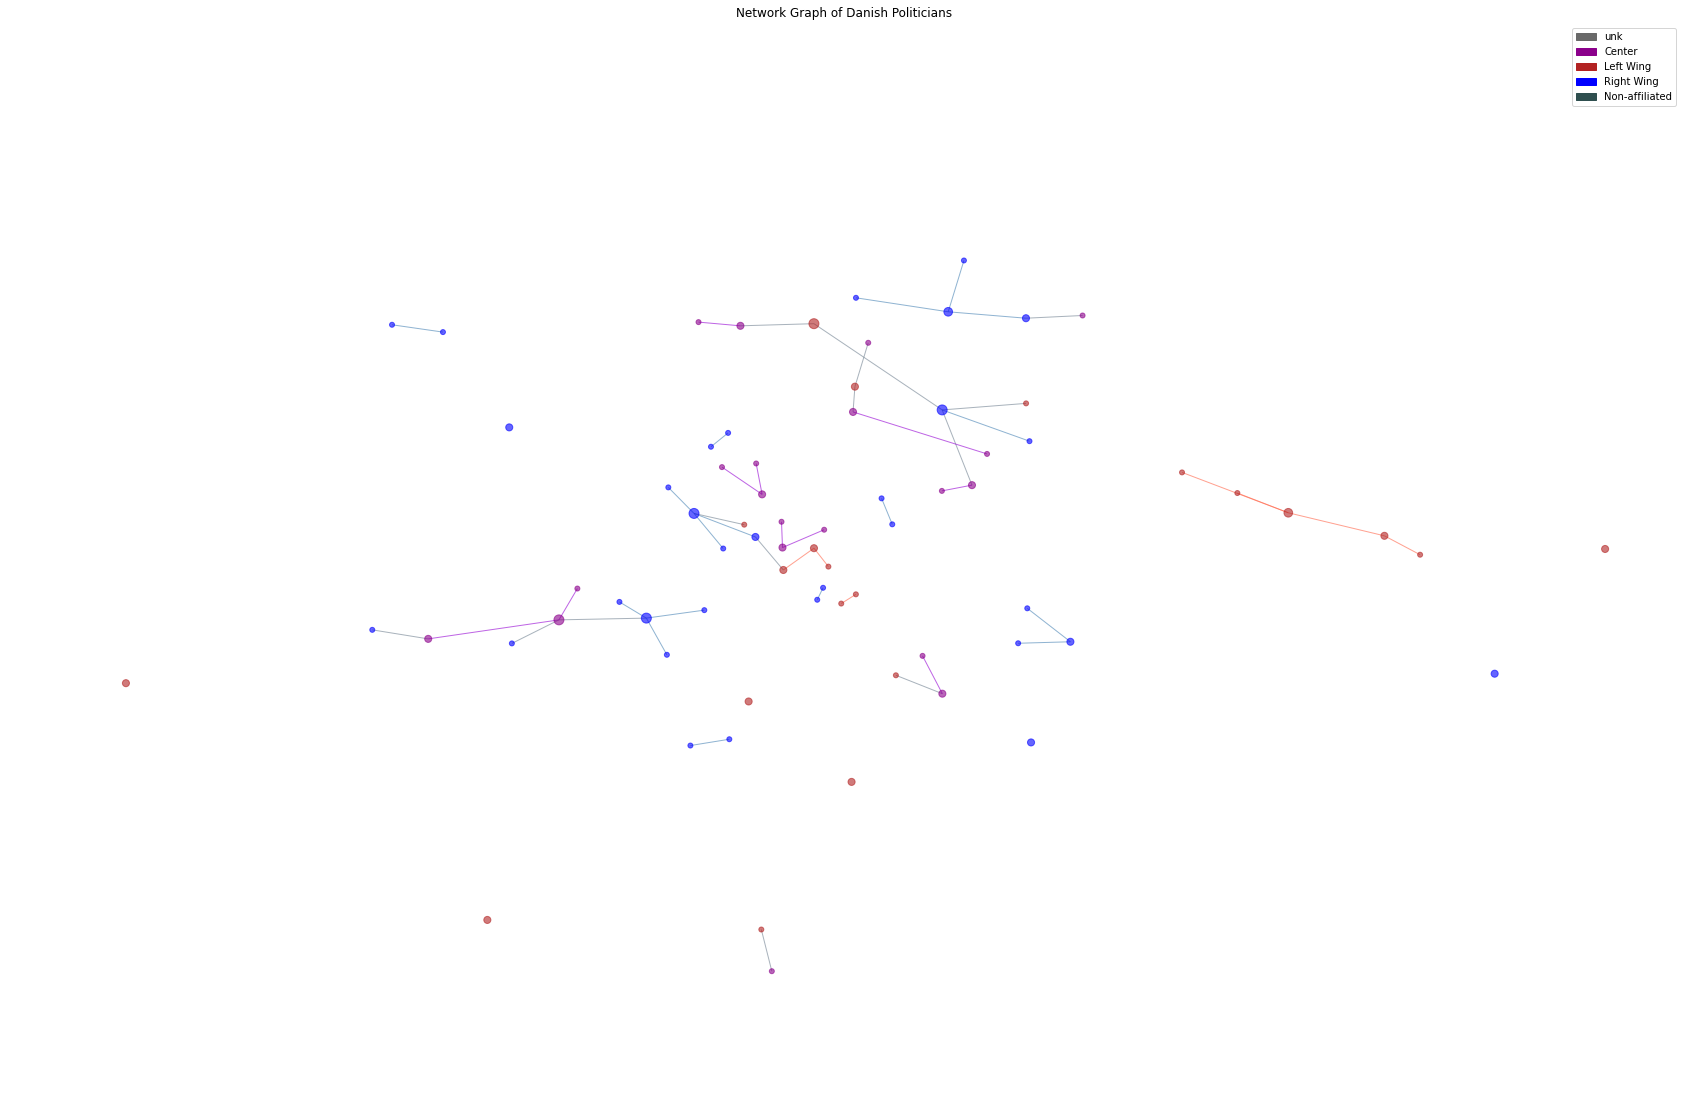

In [541]:
color_map_nodes, color_map_edge, degree_dict = color_maps(G_visualize, pol_spec = True)

## Plotting network ## 
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=80,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_visualize, pos=None, iterations=2000)

nx.draw_networkx(G_visualize, positions_full,nodelist=degree_dict.keys(), node_size=[v * 25 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=False, labels = color_map_legend_pol_spectrum.items())

plt.axis('off')
plt.title('Network Graph of Danish Politicians')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

**Figure C.5.2.3:** The network of Danish parliamentary candidates on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to idiological affiliation.

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 41635.56it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


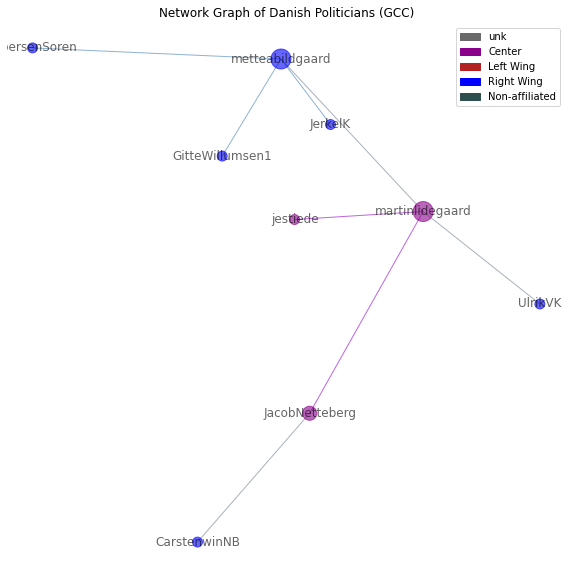

In [542]:
color_map_nodes, color_map_edge, degree_dict = color_maps(gcc_visualize, pol_spec = True)

## Plotting network (GCC) ##
plt.figure(figsize = (10,10))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc_visualize, pos=None, iterations=2000)

nx.draw_networkx(gcc_visualize, positions_gcc,nodelist=degree_dict.keys(), node_size=[v * 100 for v in degree_dict.values()], node_color = color_map_nodes,alpha = 0.6, edge_color = color_map_edge,with_labels=True)

plt.axis('off')
plt.title('Network Graph of Danish Politicians (GCC)')
plt.legend(handles = handles_dict_pol_spec)
plt.show()

**Figure C.5.2.4:** The greatest connected component in the network of Danish parliamentary candidates on Twitter #DKPOL visualized. Nodes are users and they are linked with every mention/retweet. Node-size is determined by the total degre of the node. Both nodes and edges are colored according to idiological affiliation. The GCC seems to be Twitter interaction between users belonging to right-wing and center parties.

**C.5.3 Finding communities:**

In [543]:
part = community_louvain.best_partition(G_visualize)

In [544]:
comms = np.unique(list(part.values()))

In [545]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in part.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(G_visualize, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9233610341643577


In [546]:
print("Number of found communities:")
print(max(comms))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
234
Number of communities with more than 3 nodes: 10


In [547]:
# Reorganizing into dict
d_input = dict(part.items())
res = {}

for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

In [548]:
## Print top 16 communities and their sizes ##
c = 0
top_comms = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:16]
comm_tweets = []

for i,t in enumerate(top_comms):
    comm_tweets.append(np.concatenate(tweets_w_mentions.loc[tweets_w_mentions['user_handle'].isin(t[1])]['tokenized'].values))
    
    print(f"Community {i+1}. Size: {len(t[1])}")
    c += len(t[1])
    
print(f"\nCirca {int(np.round(c/len(G_visualize.nodes), 2)*100)}% of network nodes represented in these partitions.")

Community 1. Size: 9
Community 2. Size: 8
Community 3. Size: 8
Community 4. Size: 5
Community 5. Size: 5
Community 6. Size: 4
Community 7. Size: 3
Community 8. Size: 3
Community 9. Size: 3
Community 10. Size: 3
Community 11. Size: 2
Community 12. Size: 2
Community 13. Size: 2
Community 14. Size: 2
Community 15. Size: 2
Community 16. Size: 2

Circa 22% of network nodes represented in these partitions.


**C.5.4 Permutation Test for Community Impurity**

In determing to which degree politicians mainly mention eachother within parties, i.e., how much of a political echo chamber effet there is in the found communities, a permutation test for community impurity will be conducted with 100 trials. The Gini impurity is computed from

$\widehat{\Gamma}(C)=\sum_{j=1}^J \widehat{\phi}_j(C)\left(1-\widehat{\phi}_j(C)\right)$ [5]

where $\widehat{\phi}_j(C)$ is the community party proportion for community *C*. <br><br>
In the permutation test the following steps are repeated for K trials:
1. Shuffle edges randomly to create new graph.
2. Partition with Louvain algorithm.
3. Compute average Gini impurity score for communities.

In [418]:
# Get list of unique parties prsent in communities and their counts (of occurence)
unique_list, count_list = unique_and_count(list(nx.get_node_attributes(G_visualize,'party').values()))

# Restructure in dict
all_parties = dict(zip(unique_list, count_list))
print(all_parties)

# Only consider communities that are not islets, i.e., singleton nodes.
non_singleton_res = {k: v for k, v in res.items() if len(v) > 1}

def community_impurity(community):
    """Compute Gini impurity score for community.

        Args:
            community (dict): Dict of community including parties as keys and their occurence count as values.

        Returns:
            float: Gini impurity score of community.
    """
    party_dist = np.zeros(len(unique_list))
    
    ## Compute Gini impurity ##
    for p in get_parties(community):
        party_dist[unique_list.index(p)] += 1
    party_dist /= party_dist.sum()
    
    return 1 - (party_dist**2).sum()

def avg_impurity(communities):
    """Compute average Gini impurity score for list of communities.

        Args:
            communities (list): List of dicts of communities including parties as keys and their occurence count as values.

        Returns:
            float: Average Gini impurity score of community.
    """
    return np.mean([community_entropy(comm) for comm in communities.values()])

# The impurity of the real network
true_impurity = avg_impurity(non_singleton_res)

def run_test(K: int = 100):
    """Run label shuffling permutation test for community impurity computation K times. 

    Args:
        community (dict): Dict of community including parties as keys and their occurence count as values.

    Returns:
        list: List of average Gini impurity scores for communities for the different trials.
    """
    impurities = []
    for _ in tqdm(range(K)):
        ## Create new graph where edges are randomly shuffled ##
        node_list_swap = list(G_visualize.nodes())
        
        # Shuffle randomly
        random.shuffle(node_list_swap)
        node_list_swap = [[x] for x in node_list_swap]
        node_mapping = dict(zip(G_visualize.nodes(), node_list_swap))
        G_swap = nx.Graph(node_mapping)
        
        ## Relabel according to party affiliation ##

        # Initialize empty dict
        swap_dict = dict.fromkeys(range(0, len(tweets_w_mentions)))

        # Loop through all nodes and add its corresponding party as node attribute
        for i in range(len(G_swap.nodes)):
            try:
                j = np.where(tweets_w_mentions["user_handle"] == list(G_swap.nodes)[i])[0][0]
                swap_dict[i] = {'party':list(tweets_w_mentions['party'])[j], 'pol_spectrum':list(tweets_w_mentions['pol_spectrum'])[j]}

            # For the users not included in the dataset, but only mentioned by other users, set party affiliation as "unk"    
            except IndexError: 
                swap_dict[i] = {'party':"unk", 'pol_spectrum': "unk"}

        # Change the key values to the user handles
        swap_dict = dict(zip(list(G_swap.nodes),list(swap_dict.values()))) 

        # Set node attributes from the party affiliation dict we just defined
        nx.set_node_attributes(G_swap, swap_dict)
        
        ## Find communities ##
        part_swap = community_louvain.best_partition(G_swap)
        
        # Restructure in dict.
        comms_dict = {}
        for k, v in part.items():
            str_v_ = str(v)
            if str_v_ not in comms_dict.keys():
                comms_dict[str_v_] = [k]
            else:
                comms_dict[str_v_].append(k)
        comms_list = [v for k,v in comms_dict.items()]
        d_input = dict(part_swap.items())
        
        res = {}
        for i, v in d_input.items():
            res[v] = [i] if v not in res.keys() else res[v] + [i]
        
        # Only get communities that are not islets, i.e., singleton nodes.
        non_singleton_res_swap = {k: v for k, v in res.items() if len(v) > 1}
        
        # Compute average Gini impurity score for communities and append
        impurities.append(avg_impurity(non_singleton_res_swap))
    return impurities

{'A': 25, 'B': 32, 'C': 33, 'D': 19, 'F': 21, 'I': 24, 'K': 11, 'M': 13, 'O': 16, 'Q': 2, 'UDEN': 2, 'V': 30, 'Å': 23, 'Æ': 12, 'Ø': 20}


In [419]:
# Run permutation test
impurities = run_test()

  0%|          | 0/100 [00:00<?, ?it/s]

[]

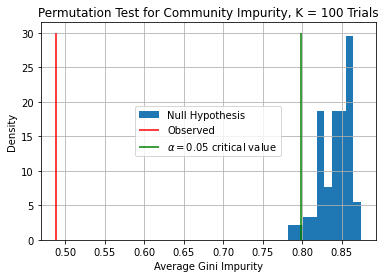

In [583]:
## Historgram ##
plt.hist(impurities, density=True, label="Null Hypothesis")
plt.vlines(true_impurity, 0, 30, color="red", label="Observed")
plt.vlines(sorted(impurities)[int(0.05/2*100)], 0, 30, color="green", label=r"$\alpha=0.05$ critical value")
plt.title("Permutation Test for Community Impurity, K = 100 Trials")
plt.xlabel("Average Gini Impurity")
plt.ylabel("Density")

# Put a legend to the right of the current axis
plt.legend(loc='center')
plt.grid()
#plt.legend(loc='lower right')
plt.plot()

**Figure C.5.4.1:** 
* H1: The observed average community impurity is different from the average community impurity for the permuted data.
* H0: The observed average community impurity is equals the average community impurity for the permuted data.

We can see from the figure above that the observed value for average community impurity is lower than the critical value of 0.05. Accordingly, we can thus accept the null hypothesis and reject the alternative hypothesis H1. Since it is proven that the observed average community impurity for the network is statistically significantly different from that of random networks with permuted edges, one can conclusively say that parties have a significant effect on the formation of communities.

**C.5.5 Inspect Party Affiliation of Users in Top Communities**

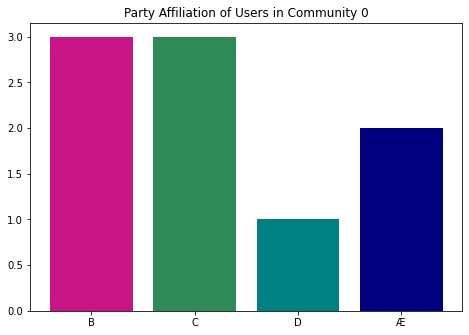

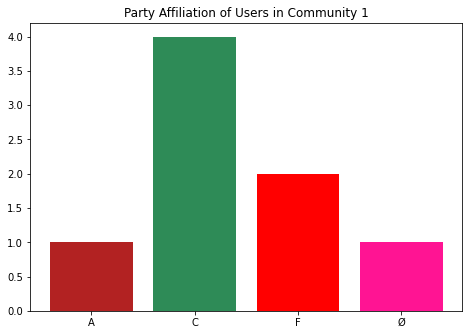

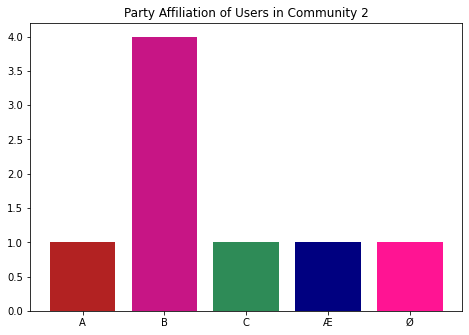

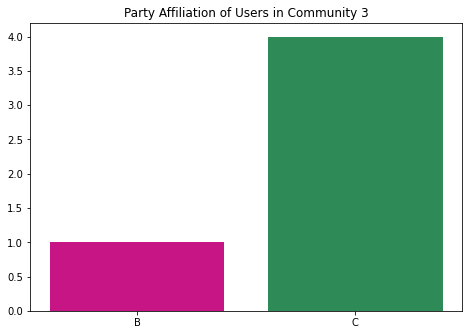

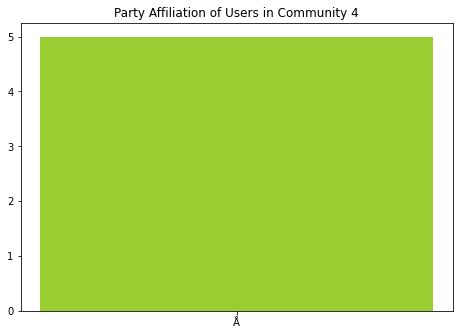

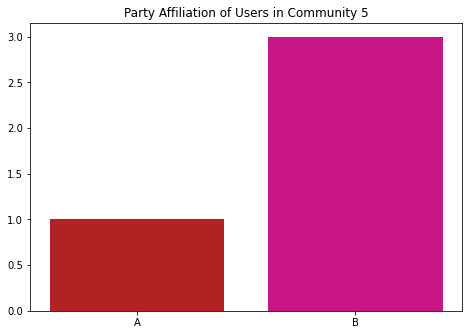

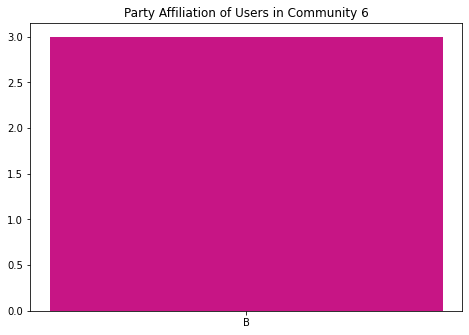

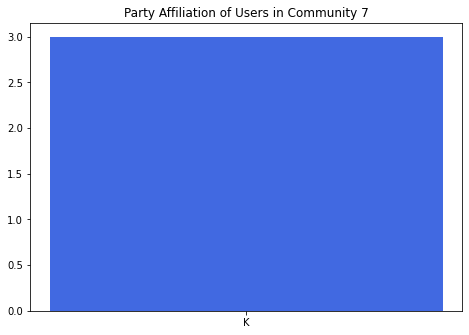

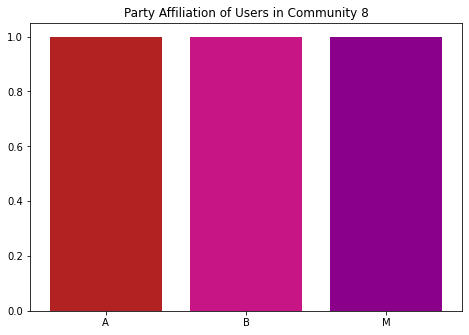

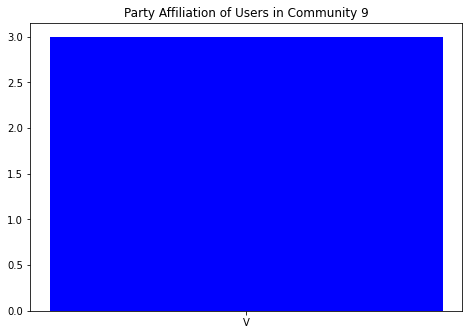

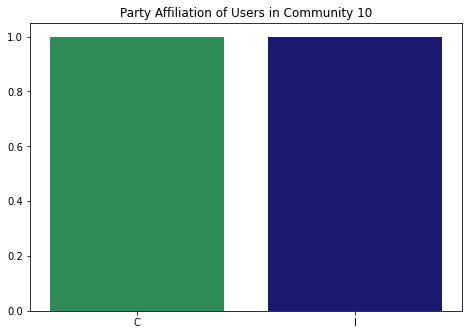

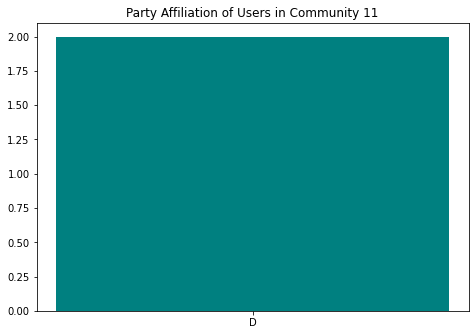

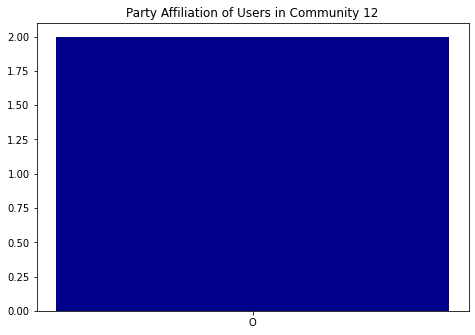

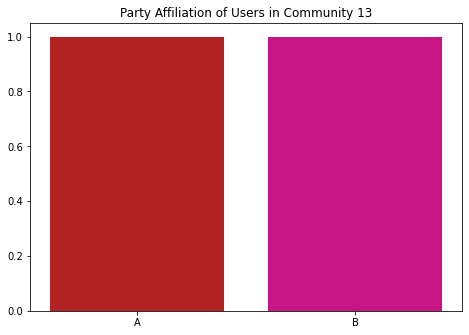

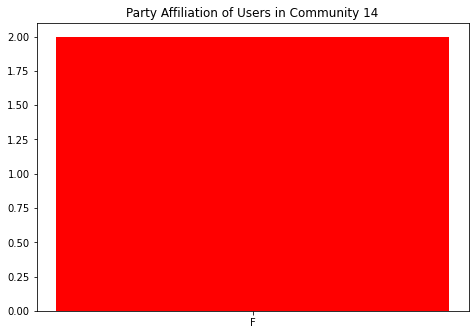

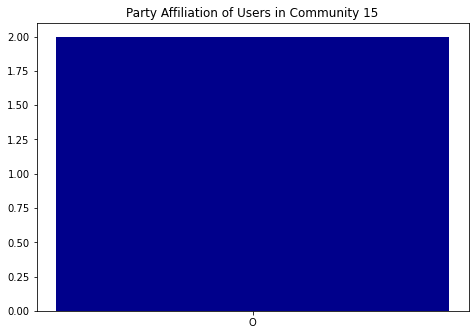

In [319]:
for i, _ in enumerate(top_comms):
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    party_aff_plot(unique_list, count_list, f"Party Affiliation of Users in Community {i}", color_dict)

**Figure C.5.5.1:** Distribution of parties within the found communities.

In [393]:
for i, _ in enumerate(top_comms):
    print(f"Parties in Community {i+1}:")
    unique_list, count_list = unique_and_count(get_parties(top_comms[i][1]))
    print(dict(zip(unique_list, count_list)))
    print(" ")

Parties in Community 1:
{'B': 3, 'C': 3, 'D': 1, 'Æ': 2}
 
Parties in Community 2:
{'A': 1, 'C': 4, 'F': 2, 'Ø': 1}
 
Parties in Community 3:
{'A': 1, 'B': 4, 'C': 1, 'Æ': 1, 'Ø': 1}
 
Parties in Community 4:
{'B': 1, 'C': 4}
 
Parties in Community 5:
{'Å': 5}
 
Parties in Community 6:
{'A': 1, 'B': 3}
 
Parties in Community 7:
{'B': 3}
 
Parties in Community 8:
{'K': 3}
 
Parties in Community 9:
{'A': 1, 'B': 1, 'M': 1}
 
Parties in Community 10:
{'V': 3}
 
Parties in Community 11:
{'C': 1, 'I': 1}
 
Parties in Community 12:
{'D': 2}
 
Parties in Community 13:
{'O': 2}
 
Parties in Community 14:
{'A': 1, 'B': 1}
 
Parties in Community 15:
{'F': 2}
 
Parties in Community 16:
{'O': 2}
 


**C.5.6 Visualizing TF-IDF Word Clouds for Top 16 Communities**

For detailed explanation, see **C.3.3**.

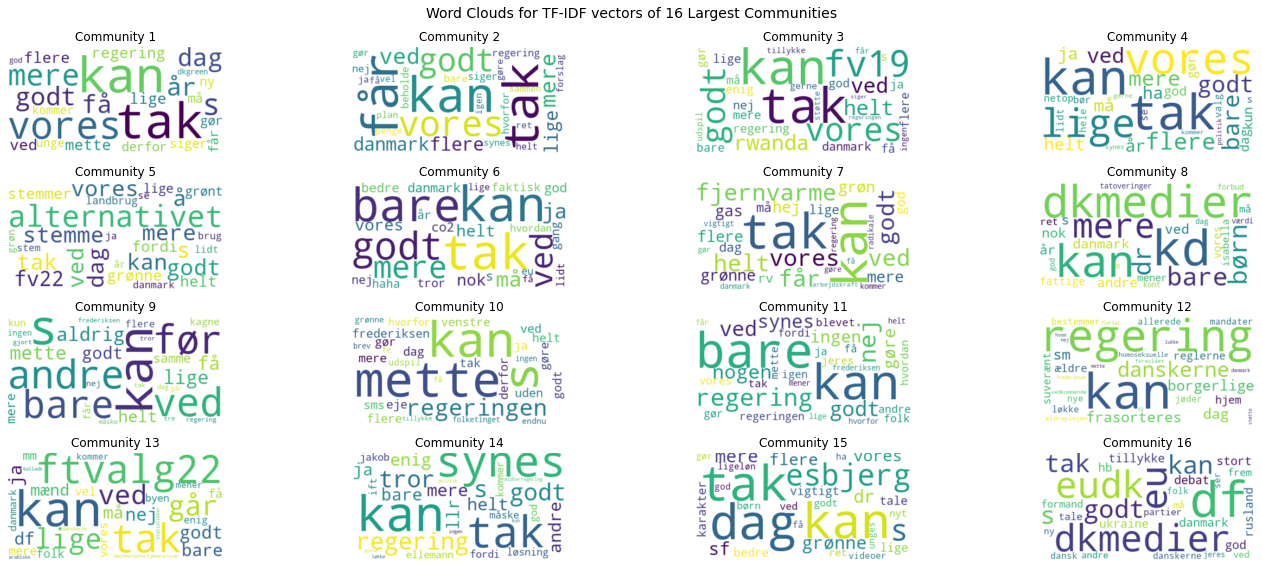

In [321]:
# Calculate TF
tf_tweets = pd.Series(comm_tweets).apply(nltk.FreqDist)

# Compute document frequency
d_freq = nltk.FreqDist(np.concatenate(pd.Series(comm_tweets).apply(lambda x: list(set(x))).values))

# Compute IDF
N = 16
idf_vals = np.log10(((1+N)/(1+np.array(list(d_freq.values()))))) + 1

idf = dict(zip(d_freq.keys(), idf_vals))
series_TF_IDF = pd.Series(tf_tweets).apply(lambda x: tf_idf(x, idf))

fig, ax = plt.subplots(4, 4, figsize= (20, 8))

c = 0
for i in range(4):
    for j in range(4):
        w_list = sorted(series_TF_IDF[c], key=series_TF_IDF[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(w_list))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
        
fig.suptitle("Word Clouds for TF-IDF vectors of 16 Largest Communities", fontsize = 14)
fig.tight_layout()
plt.show()

**Figure C.5.6.1:** Removing the 'unk' nodes, it is evident that the bot community about music is now gone.

# D. References

[1] Blondel, V.D., et. al. "Fast unfolding of communities in large networks," IOPSCIENCE 2008 URL: https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/pdf

[2] S. Fortunato and M. Barthélemy. "Resolution limit in community detection," PNAS 2007 URL:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1765466/

[3] Mark Newman. "Networks - Second Edition," OXFORD UNIVERSITY PRESS 2018 URL:
https://books.google.dk/books?hl=da&lr=&id=YdZjDwAAQBAJ&oi=fnd&pg=PP1&ots=V-L35Il9sw&sig=UxeoogJyH1RIx3t79ZtONwgr04A&redir_esc=y#v=onepage&q&f=false

[4] Linton C. Freeman. "A Set of Measures of Centrality Based on Betweenness," Sociometry 1977 URL:
https://www.jstor.org/stable/3033543?origin=crossref#metadata_info_tab_contents

[5] S. Nembrini, et. al. "The revival of the Gini importance?," Bioinformatics 2018 URL:
https://www.jstor.org/stable/3033543?origin=crossref#metadata_info_tab_contents

[6] S. Qaiser and R. Ali. "Text Mining: Use of TF-IDF to Examine the Relevance of Words to Documents," International Journal of Computer Applications 2018 URL:
https://www.researchgate.net/publication/326425709_Text_Mining_Use_of_TF-IDF_to_Examine_the_Relevance_of_Words_to_Documents

[7] M. E. J. Newman. "Modularity and community structure in networks," PNAS 2008 URL:
https://www.pnas.org/doi/10.1073/pnas.0601602103

[8] V. Kumar, et. al. "Comparing Algorithms of Community Structure in Networks," Indian Journal of Science and Technology 2016 URL: https://indjst.org/download-article.php?Article_Unique_Id=INDJST9348&Full_Text_Pdf_Download=True

[9]  Albert-László Barabási. "Network Science," Cambridge University Press 2016 URL: http://networksciencebook.com/